In [1]:
# IMPORTS, FILE LOADS, DETECTRON, RENDERER PREP ETC.
from pathlib import Path
import torch
import argparse
import os
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import cv2
import numpy as np
from hamer.configs import CACHE_DIR_HAMER
from hamer.models import HAMER, download_models, load_hamer, DEFAULT_CHECKPOINT
from hamer.utils import recursive_to
from hamer.datasets.vitdet_dataset import ViTDetDataset, DEFAULT_MEAN, DEFAULT_STD
from hamer.utils.renderer import Renderer, cam_crop_to_full
from vitpose_model import ViTPoseModel
import matplotlib.pyplot as plt
import json
from typing import Dict, Optional
import open3d as o3d
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import matplotlib.pyplot as plt
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import imageio.v3 as iio
import open3d as o3d
import numpy as np
import mediapipe   as mp
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import time
import mano
from mano.utils import Mesh, Struct, colors, to_np, to_tensor
import pickle
import os.path as osp
import trimesh
from mano import lbs
from mano.joints_info import TIP_IDS

args = argparse.Namespace()
args.checkpoint = DEFAULT_CHECKPOINT
args.img_folder = 'example_data'
args.out_folder = 'demo_out'
args.side_view = True
args.full_frame = True
args.save_mesh = True
args.batch_size = 1
args.rescale_factor = 2.0
args.body_detector = 'vitdet'
args.file_type = ['*.jpg', '*.png']

T_OPENGL_TO_OPENCV = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
HUMAN_HAND_COLOR=(0.999, 0.6745, 0.4117)
# intrinsics_camera = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/head_cam_intrinsic_matrix_aligned_depth.npy")
intrinsics_camera = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/iphone_vid_2/intrinsics_iphone.npy")

# IM_WIDTH = 640
# IM_HEIGHT = 480

# hands_rgb = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/rgbs_open_place.npy")
# hands_depth = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/depths_open_place.npy")

hands_rgb = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/iphone_vid_2/rgb.npy")
hands_depth = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/iphone_vid_2/depth.npy")

IM_WIDTH = hands_rgb[0].shape[1]
IM_HEIGHT = hands_rgb[0].shape[0]

# show rgbs as video
for i in range(hands_rgb.shape[0]):
    im = cv2.cvtColor(hands_rgb[i], cv2.COLOR_BGR2RGB)
    # im = cv2.cvtColor(hands_depth[i],cv2.COLOR_GRAY2BGR)
    cv2.imshow("rgb", im)
    cv2.waitKey(1)
    time.sleep(0.01)

cv2.destroyAllWindows()
# Download and load checkpoints
download_models(CACHE_DIR_HAMER)
model, model_cfg = load_hamer(args.checkpoint)
# Setup HaMeR model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
model.eval()
# Load detector
from hamer.utils.utils_detectron2 import DefaultPredictor_Lazy
if args.body_detector == 'vitdet':
    from detectron2.config import LazyConfig
    import hamer
    cfg_path = Path(hamer.__file__).parent/'configs'/'cascade_mask_rcnn_vitdet_h_75ep.py'
    detectron2_cfg = LazyConfig.load(str(cfg_path))
    detectron2_cfg.train.init_checkpoint = "https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/cascade_mask_rcnn_vitdet_h/f328730692/model_final_f05665.pkl"
    for i in range(3):
        detectron2_cfg.model.roi_heads.box_predictors[i].test_score_thresh = 0.25
    detector = DefaultPredictor_Lazy(detectron2_cfg)
elif args.body_detector == 'regnety':
    from detectron2 import model_zoo
    from detectron2.config import get_cfg
    detectron2_cfg = model_zoo.get_config('new_baselines/mask_rcnn_regnety_4gf_dds_FPN_400ep_LSJ.py', trained=True)
    detectron2_cfg.model.roi_heads.box_predictor.test_score_thresh = 0.5
    detectron2_cfg.model.roi_heads.box_predictor.test_nms_thresh   = 0.4
    detector       = DefaultPredictor_Lazy(detectron2_cfg)
# keypoint detector
cpm = ViTPoseModel(device)
# Setup the renderer
renderer = Renderer(model_cfg, faces=model.mano.faces, load_from_custom_file=True)

print("Existing focal length: ", model_cfg.EXTRA.FOCAL_LENGTH)
# model_cfg.EXTRA.FOCAL_LENGTH = intrinsics_kinect[0, 0]
# Make output directory if it does not exist
os.makedirs(args.out_folder, exist_ok=True)

MANO_HAND_IDS = {"wrist": 0, "index_mcp": 1, "index_pip": 2, "index_dip": 3, "middle_mcp": 4, "middle_pip": 5, "middle_dip": 6, "pinkie_mcp": 7, "pinkie_pip": 8, "pinkie_dip": 9,
                "ring_mcp": 10, "ring_pip": 11, "ring_dip": 12, "thumb_mcp": 13, "thumb_pip": 14, "thumb_dip": 15, "thumb_tip": 16, "index_tip": 17, "middle_tip": 18, "ring_tip": 19,
                "pinky_tip": 20}



/Users/george/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/george/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


apex is not installed
apex is not installed
apex is not installed


/Users/george/anaconda3/lib/python3.11/site-packages/mmcv/cnn/bricks/transformer.py:27: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


[05/07 10:48:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/cascade_mask_rcnn_vitdet_h/f328730692/model_final_f05665.pkl ...
[05/07 10:48:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024)]
Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.blocks.0.mlp.experts.0.weight, backbone.blocks.0.mlp.experts.0.bias, backbone.blocks.0.mlp.experts.1.weight, backbone.blocks.0.mlp.experts.1.bias, backbone.blocks.0.mlp.experts.2.weight, backbone.blocks.0.mlp.experts.2.bias, backbone.blocks.0.mlp.experts.3.weight, backbone.blocks.0.mlp.experts.3.bias, backbone.blocks.0.mlp.experts.4.weight, backbone.blocks.0.mlp.experts.4.bias, backbone.blocks.0.mlp.experts.5.weight, backbone.blocks.0.mlp.experts.5.bias, backbone.blocks.1.mlp.experts.0.weight, backbon

In [3]:
def point_cloud_to_depth_image(point_cloud, fx, fy, cx, cy, width=1280, height=720):
    """
    Convert a 3D point cloud into a depth image.
    
    Parameters:
    - point_cloud: A 2D numpy array of shape (N, 3), containing the (X, Y, Z) coordinates of each point.
    - fx, fy: The focal lengths of the camera in pixels.
    - cx, cy: The optical center (principal point) of the camera, typically the image center.
    - width, height: The dimensions of the resulting depth image.
    
    Returns:
    - A 2D numpy array of shape (height, width), representing the depth image, where each pixel contains
      the depth value of the corresponding point in the point cloud. Pixels with no corresponding point
      are set to 0.
    """
    # Initialize the depth image with zeros (no depth)
    depth_image = np.zeros((height, width), dtype=np.float32)
    
    # Extract X, Y, Z coordinates
    X, Y, Z = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]
    
    # Exclude points with no depth or behind the camera
    # valid = Z > 0
    # X = X[valid]
    # Y = Y[valid]
    # Z = Z[valid]
    
    # Project points onto the image plane
    u = (X * fx / Z) + cx
    v = (Y * fy / Z) + cy
    
    # Convert coordinates to integer pixel indices
    u = np.round(u).astype(int)
    v = np.round(v).astype(int)
    
    # Filter out points that fall outside the image
    valid = (u >= 0) & (u < width) & (v >= 0) & (v < height)
    u = u[valid]
    v = v[valid]
    Z = Z[valid]
    
    # Update the depth image
    depth_image[v, u] = Z
    
    return depth_image

def depth_to_point_cloud(depth_im, fx, fy, cx, cy):
    rows, cols = depth_im.shape
    x = np.arange(0, cols)
    y = np.arange(0, rows)
    xx, yy = np.meshgrid(x, y)
    X = (xx - cx) * depth_im / fx
    Y = (yy - cy) * depth_im / fy
    Z = depth_im
    return np.stack([X, Y, Z], axis=-1)

def find_scaled_transformation(p, q, use_scale=True):
    # p, q are Nx3 arrays of corresponding points
    # Calculate centroids
    Cp = np.mean(p, axis=0)
    Cq = np.mean(q, axis=0)
    # Center points around the centroids
    p_centered = p - Cp
    q_centered = q - Cq
    # Compute scale
    # Using the ratio of sums of distances from the centroids
    scale = np.sqrt((q_centered ** 2).sum() / (p_centered ** 2).sum())

    if not use_scale:
        scale = 1
    # Compute covariance matrix H
    H = np.dot(p_centered.T, q_centered)
    # SVD on covariance matrix
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    # Ensure a proper rotation matrix (det(R) = 1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)
    # Compute translation
    t = Cq.T - scale * np.dot(R, Cp.T)
    # Construct the transformation matrix
    T = np.eye(4)
    T[:3, :3] = scale * R
    T[:3, 3] = t
    return T

def apply_transformation(p, T):
    """
    Apply a 4x4 transformation matrix to a set of 3D points.

    Parameters:
    - p: A 2D numpy array of shape (N, 3), containing the (X, Y, Z) coordinates of each point.
    - T: The 4x4 transformation matrix.

    Returns:
    - A 2D numpy array of shape (N, 3), containing the transformed (X, Y, Z) coordinates.
    """
    # Homogenize the points in p
    p_homogeneous = np.hstack((p, np.ones((p.shape[0], 1))))
    # Apply the transformation matrix to each point
    p_transformed_homogeneous = np.dot(T, p_homogeneous.T).T
    # Dehomogenize the points
    p_transformed = p_transformed_homogeneous[:, :3] / p_transformed_homogeneous[:, 3, np.newaxis]    
    return p_transformed

def compute_principal_axis(point_cloud, switch_principal_axis=False, return_eigenstuff=False):
    # Extract principal axis of the point cloud
    # Compute the covariance matrix
    cov = np.cov(point_cloud.T)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # Sort the eigenvectors by decreasing eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Extract the principal axis
    principal_axis = eigenvectors[:, 0]
    second_axis = eigenvectors[:, 1]
    # Make the vector longer by keep its direction
    principal_axis = principal_axis * 10
    second_axis = second_axis * 10
    if return_eigenstuff:
        return eigenvalues, eigenvectors
    if switch_principal_axis:
        # return second_axis, principal_axis 
        return second_axis, eigenvectors[:, 2] * 10
    return principal_axis, second_axis

def scale_gripper_match_hand(gripper_pcd, hand_pcd, vizualize=False):

    """Scaled the gripper to match the hand 1-to-1
    This is approximate and may not need to be engineered; but that's okay.
    """
    gripper_bb = gripper_pcd.get_axis_aligned_bounding_box()
    hand_bb = hand_pcd.get_axis_aligned_bounding_box()
    # get bounding box volume
    volume_ratio = hand_bb.volume() / gripper_bb.volume()

    gripper = gripper_pcd.points
    hand = hand_pcd.points
    scale_x = (hand_bb.get_max_bound()[0] - hand_bb.get_min_bound()[0]) / (gripper_bb.get_max_bound()[0] - gripper_bb.get_min_bound()[0])
    scale_y = (hand_bb.get_max_bound()[1] - hand_bb.get_min_bound()[1]) / (gripper_bb.get_max_bound()[1] - gripper_bb.get_min_bound()[1])
    scale_z = (hand_bb.get_max_bound()[2] - hand_bb.get_min_bound()[2]) / (gripper_bb.get_max_bound()[2] - gripper_bb.get_min_bound()[2])
    center = gripper_pcd.get_center()
    mean_scaling = (scale_x + scale_y + scale_z) / 3
    # pcd_scaled = (gripper - center) * np.array([scale_x, scale_y, scale_z]) + center
    pcd_scaled = (gripper - center) * np.array([mean_scaling, mean_scaling, mean_scaling]) + center

    pcd_scaled_o3d = o3d.geometry.PointCloud()
    pcd_scaled_o3d.points = o3d.utility.Vector3dVector(pcd_scaled)

    if vizualize:
        o3d.visualization.draw_geometries([pcd_scaled_o3d, hand_pcd])
        
    return pcd_scaled_o3d

def np_to_o3d(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd
def interpolate_rotation(r1, r2, num_steps):
    r1 = R.from_matrix(r1)
    r2 = R.from_matrix(r2)
    # r1 and r2 in one Rotation instance
    key_rots = R.from_matrix([r1.as_matrix(), r2.as_matrix()])
    # interpolate with Slerp
    slerp = Slerp([0, 1], key_rots)
    times = np.linspace(0, 1, num_steps)
    qs = slerp(times)

    return qs

def interpolate_translation(t1, t2, num_steps):
    ts = np.zeros((num_steps, 3))
    for i in range(num_steps):
        ts[i] = t1 + (t2 - t1) * i / (num_steps - 1)
    return ts

def interpolate_pose(pose1, pose2, num_steps):
    r1 = pose1[:3, :3]
    t1 = pose1[:3, 3]
    r2 = pose2[:3, :3]
    t2 = pose2[:3, 3]
    rs = interpolate_rotation(r1, r2, num_steps)
    ts = interpolate_translation(t1, t2, num_steps)
    poses = np.zeros((num_steps, 4, 4))
    for i in range(num_steps):
        print(rs[i])
        poses[i, :3, :3] = rs[i].as_matrix() #R.from_quat(rs[i]).as_matrix()
        poses[i, :3, 3] = ts[i]
        poses[i, 3, 3] = 1
    return poses

def interpolate_pose_sequence(poses, num_steps):
    interpolated_poses = []
    for i in range(len(poses) - 1):
        interpolated_poses.append(interpolate_pose(poses[i], poses[i + 1], num_steps))
    return np.vstack(interpolated_poses)




In [4]:
from mano.joints_info import TIP_IDS

def get_hand_and_rendered_depth(rgb):
    # Get all demo images ends with .jpg or .png
    # Iterate over all images in folder
    img_cv2 = rgb
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # Detect humans in image
    det_out = detector(img_cv2)
    img = img_cv2.copy()[:, :, ::-1]
    det_instances = det_out['instances']
    valid_idx = (det_instances.pred_classes==0) & (det_instances.scores > 0.5)
    pred_bboxes=det_instances.pred_boxes.tensor[valid_idx].cpu().numpy()
    pred_scores=det_instances.scores[valid_idx].cpu().numpy()
    # Detect human keypoints for each person
    vitposes_out = cpm.predict_pose(img, [np.concatenate([pred_bboxes, pred_scores[:, None]], axis=1)],)
    bboxes = []
    is_right = []
    # Use hands based on hand keypoint detections
    for vitposes in vitposes_out:
        left_hand_keyp = vitposes['keypoints'][-42:-21]
        right_hand_keyp = vitposes['keypoints'][-21:]
        # Rejecting not confident detections
        keyp = left_hand_keyp
        valid = keyp[:,2] > 0.5
        if sum(valid) > 3:
            bbox = [keyp[valid,0].min(), keyp[valid,1].min(), keyp[valid,0].max(), keyp[valid,1].max()]
            bboxes.append(bbox)
            is_right.append(0)
        keyp = right_hand_keyp
        valid = keyp[:,2] > 0.5
        if sum(valid) > 3:
            bbox = [keyp[valid,0].min(), keyp[valid,1].min(), keyp[valid,0].max(), keyp[valid,1].max()]
            bboxes.append(bbox)
            is_right.append(1)

    boxes = np.stack(bboxes)
    right = np.stack(is_right)
    # Run reconstruction on all detected hands
    dataset = ViTDetDataset(model_cfg, img_cv2, boxes, right, rescale_factor=args.rescale_factor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
    all_verts = []
    all_cam_t = []
    all_right = []
    
    for batch in dataloader:
        batch = recursive_to(batch, device)
        with torch.no_grad():
            out = model(batch)
        multiplier = (2*batch['right']-1)
        pred_cam = out['pred_cam']
        pred_cam[:,1] = multiplier*pred_cam[:,1]
        box_center = batch["box_center"].float()
        box_size = batch["box_size"].float()
        img_size = batch["img_size"].float()
        multiplier = (2*batch['right']-1)
        scaled_focal_length = model_cfg.EXTRA.FOCAL_LENGTH / model_cfg.MODEL.IMAGE_SIZE * img_size.max()
        pred_cam_t_full = cam_crop_to_full(pred_cam, box_center, box_size, img_size, scaled_focal_length).detach().cpu().numpy()
        # Render the result
        batch_size = batch['img'].shape[0]
        print(f'Batch size: {batch_size}')
        for n in range(batch_size):
            # Get filename from path img_path
            input_patch = batch['img'][n].cpu() * (DEFAULT_STD[:,None,None]/255) + (DEFAULT_MEAN[:,None,None]/255)
            input_patch = input_patch.permute(1,2,0).numpy()
            # Add all verts and cams to list
            verts = out['pred_vertices'][n].detach().cpu().numpy()
            is_right = batch['right'][n].cpu().numpy()
            verts[:,0] = (2*is_right-1)*verts[:,0]
            cam_t = pred_cam_t_full[n]
            all_verts.append(verts)
            all_cam_t.append(cam_t)
            all_right.append(is_right)
    all_verts_as_np = np.asarray(all_verts)
    all_verts_as_np = all_verts_as_np[0]
    all_verts_list = [all_verts_as_np]

    misc_args = dict(
        mesh_base_color=HUMAN_HAND_COLOR,
        scene_bg_color=(1, 1, 1),
        focal_length=scaled_focal_length,
    )
    cam_view, rend_depth_front_view, mesh_list = renderer.render_rgba_multiple(all_verts_list, cam_t=all_cam_t, render_res=img_size[n], is_right=all_right, **misc_args)
    # Overlay image
    input_img = img_cv2.astype(np.float32)[:,:,::-1]/255.0
    input_img = np.concatenate([input_img, np.ones_like(input_img[:,:,:1])], axis=2) # Add alpha channel
    input_img_overlay = input_img[:,:,:3] * (1-cam_view[:,:,3:]) + cam_view[:,:,:3] * cam_view[:,:,3:]
    camera_translation = cam_t.copy()
    hand_mesh = renderer.vertices_to_trimesh(verts, camera_translation, HUMAN_HAND_COLOR, is_right=is_right)
    return input_img_overlay, cam_view, rend_depth_front_view, det_out, out, (hand_mesh, camera_translation, verts), (mesh_list, all_cam_t, all_verts)


def get_hand_mask_from_detectron(det_out, show_mask=False, rgb_im=None):
    if show_mask and rgb_im is not None:
        # Create config. THESE ARE ONLY USED FOR THE VIZUALIZER
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
        # Make prediction
        outputs = det_out
        v = Visualizer(rgb_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # # Extract person mask
    # # print(np.argwhere(outputs['instances'].pred_classes == 0)[0, 0])
    # human_mask = outputs["instances"].pred_masks[np.argwhere(outputs['instances'].pred_classes == 0)[0,0].item()].cpu().numpy()
    # Extract person mask
    human_mask = det_out["instances"].pred_masks[np.argwhere(det_out['instances'].pred_classes == 0)[0,0].item()].cpu().numpy()
    return human_mask


def get_hand_keypoints_from_mediapipe(rgb_im, viz_keypoints=False):
    # # Initialize MediaPipe Hands.
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
    color_image = copy.deepcopy((rgb_im * 255.0).astype(np.uint8))
    # Process the image to find hand landmarks.
    results = hands.process(color_image)
    d_val = -1
    # Draw the hand landmarks on the image.
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                # Draw a circle on the image.
                cx, cy = int(landmark.x * color_image.shape[1]), int(landmark.y * color_image.shape[0])
                cv.circle(color_image, (cx, cy), 5, (0, 255, 0), -1)
    mp_drawing = mp.solutions.drawing_utils
    image = color_image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            # Example: Get the tip of the index finger
            index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
            # print(f"Index Finger Tip Coordinates: (x: {index_tip.x}, y: {index_tip.y}, z: {index_tip.z})")
            index_x, index_y = int(index_tip.x * image.shape[1]), int(index_tip.y * image.shape[0])
            thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
            # print(f"Thumb Tip Coordinates: (x: {thumb_tip.x}, y: {thumb_tip.y}, z: {thumb_tip.z})")
            thumb_x, thumb_y = int(thumb_tip.x * image.shape[1]), int(thumb_tip.y * image.shape[0])
            middle_tip = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP]
            # print(f"Middle Finger Tip Coordinates: (x: {middle_tip.x}, y: {middle_tip.y}, z: {middle_tip.z})")
            middle_x, middle_y = int(middle_tip.x * image.shape[1]), int(middle_tip.y * image.shape[0])
    # Extract a hand mesh from the hand landmarks and display it.
    hand_mesh = mp_hands.HAND_CONNECTIONS
    hand_mesh = [list(pair) for pair in hand_mesh]
    # Draw the hand mesh on the image.
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for connection in hand_mesh:
                # Get the coordinates of the two points.
                start = (int(hand_landmarks.landmark[connection[0]].x * image.shape[1]),
                        int(hand_landmarks.landmark[connection[0]].y * image.shape[0]))
                end = (int(hand_landmarks.landmark[connection[1]].x * image.shape[1]),
                    int(hand_landmarks.landmark[connection[1]].y * image.shape[0]))
                # Draw a line connecting the two points.
                cv.line(image, start, end, (0, 255, 0), 2)
    # Matplotlib visualization
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()
        
    # Draw a cirlce on the pixel of the index finger tip using matplotlib.
    thumb_cmc = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC]
    thumb_cmc_x, thumb_cmc_y = int(thumb_cmc.x * image.shape[1]), int(thumb_cmc.y * image.shape[0])

    thumb_IP = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP]
    thumb_IP_x, thumb_IP_y = int(thumb_IP.x * image.shape[1]), int(thumb_IP.y * image.shape[0])

    thumb_MCP = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP]
    thumb_MCP_x, thumb_MCP_y = int(thumb_MCP.x * image.shape[1]), int(thumb_MCP.y * image.shape[0])

    index_mc = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP]
    index_mc_x, index_mc_y = int(index_mc.x * image.shape[1]), int(index_mc.y * image.shape[0])

    index_pip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP]
    index_pip_x, index_pip_y = int(index_pip.x * image.shape[1]), int(index_pip.y * image.shape[0])

    index_dip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP]
    index_dip_x, index_dip_y = int(index_dip.x * image.shape[1]), int(index_dip.y * image.shape[0])
    
    if viz_keypoints:
        plt.imshow(rgb_im)
        plt.scatter(index_x, index_y, color='blue', s=10)
        plt.scatter(index_dip_x, index_dip_y, color='orange', s=10)

        plt.scatter(index_pip_x, index_pip_y, color='purple', s=10)
        plt.scatter(thumb_x, thumb_y, color='blue', s=10)
        plt.scatter(thumb_IP_x, thumb_IP_y, color='orange', s=10)
        plt.scatter(thumb_MCP_x, thumb_MCP_y, color='purple', s=10)

    index_finger_1_x, index_finger_1_y = index_x, index_y
    index_finger_2_x, index_finger_2_y = index_dip_x, index_dip_y
    index_finger_3_x, index_finger_3_y = index_pip_x, index_pip_y

    thumb_1_x, thumb_1_y = thumb_x, thumb_y
    thumb_2_x, thumb_2_y = thumb_IP_x, thumb_IP_y
    thumb_3_x, thumb_3_y = thumb_MCP_x, thumb_MCP_y
    return middle_x, middle_y, index_finger_1_x, index_finger_1_y, index_finger_2_x, index_finger_2_y, index_finger_3_x, index_finger_3_y, thumb_1_x, thumb_1_y, thumb_2_x, thumb_2_y, thumb_3_x, thumb_3_y

def get_hand_pcd_in_scene_from_rendered_model(rgb_im, depth_im, rend_depth_front_view, new_depth_image, human_mask, vizualize=False):
    ######## INTRINSICS EXTRACTED FROM HAMER RENDERER ########
    intr = np.eye(4)
    # intr[0 ,0] = 2295.0
    # intr[1, 1] = 2295.0
    # intr[0, 2] = 320.0
    # intr[1, 2] = 240.0
    intr[0 ,0] = 918.0
    intr[1, 1] = 918.0
    intr[0, 2] = 128.0
    intr[1, 2] = 96.0
    ################
    point_cloud_ori = depth_to_point_cloud(rend_depth_front_view, intr[0, 0], intr[1, 1],  intr[0, 2],  intr[1, 2]) # Hamer intrinsics, depth at renderer's scale (does not match real)
    point_cloud_ori = point_cloud_ori.reshape(-1, 3)
    # point_cloud_ori = point_cloud_ori[point_cloud_ori[:, 2] > 0]
    point_cloud_camera = depth_to_point_cloud(depth_im, intrinsics_camera[0, 0],intrinsics_camera[1, 1], intrinsics_camera[0, 2], intrinsics_camera[1, 2]) # Camera intrinsics, depth at real scale, although the shape is not accurate
    point_cloud_camera = point_cloud_camera.reshape(-1, 3)
    # point_cloud_kinect = point_cloud_kinect[point_cloud_kinect[:, 2] > 400]
    point_cloud_rescaled_depth = depth_to_point_cloud(new_depth_image, intr[0, 0], intr[1, 1], intr[0, 2],  intr[1, 2]) # Hamer intrinsics, depth at real scale, shape does not match real
    point_cloud_rescaled_depth = point_cloud_rescaled_depth.reshape(-1, 3)
    # point_cloud_rescaled_depth = point_cloud_rescaled_depth[point_cloud_rescaled_depth[:, 2] > 400]
    # Show the point cloud in open3d
    pcd_hand_to_scale = o3d.geometry.PointCloud()
    pcd_hand_to_scale.points = o3d.utility.Vector3dVector(point_cloud_ori)
    pcd_camera = o3d.geometry.PointCloud()
    pcd_camera.points = o3d.utility.Vector3dVector(point_cloud_camera)
    pcd_rescaled_depth = o3d.geometry.PointCloud()
    pcd_rescaled_depth.points = o3d.utility.Vector3dVector(point_cloud_rescaled_depth)

    show_scaled_up_pcd = False
    remove_outliers=False # does not work that well, a big hacky
    # print("point cloud camera shape: ", point_cloud_camera.shape)
    point_cloud_camera = point_cloud_camera.reshape(IM_HEIGHT, IM_WIDTH, 3)
    point_cloud_rescaled_depth = point_cloud_rescaled_depth.reshape(IM_HEIGHT, IM_WIDTH, 3)
    # Extract common points between rendered model and live image
    common_points_binary = np.zeros_like(new_depth_image)
    common_points_binary[new_depth_image > 0] = 1 # binary mask of points in the rendered model depth

    depth_im_hand =  human_mask * depth_im # extract human hand from the live image
    depth_im_hand = common_points_binary * depth_im_hand # extract common points between rendered depth model and live image
    depth_im_hand[depth_im_hand > .8] = 0 # remove all points 2m away from the camera
    if vizualize:
        print(depth_im_hand[depth_im_hand > .5])
        plt.imshow(depth_im_hand)
        plt.title("Depth image of hand after human mask")
        plt.show()

    if remove_outliers: # a bit hacky, does not do much, if not cause problems
        mean_depth = np.mean(new_depth_image[new_depth_image > 0])
        std_depth = np.std(new_depth_image[new_depth_image > 0])
        outlier_points = np.ones_like(depth_im_hand)
        outlier_points[depth_im_hand > mean_depth + 3*std_depth] = 0
        outlier_points[depth_im_hand < mean_depth - 3*std_depth] = 0
        plt.imshow(outlier_points)
        plt.title("Outlier points")
        plt.show()
        depth_im_hand = depth_im_hand * outlier_points
        
    common_points = np.zeros_like(depth_im_hand)
    common_points[depth_im_hand > 0] = 1 # Binary mask of common points between rendered model depth and live image
    
    if vizualize:
        plt.imshow(common_points)
        plt.title("Common points")
        plt.show()

    common_pts_indices = np.argwhere(common_points > 0) # extract common points indices
    q = point_cloud_camera[common_pts_indices[:, 0], common_pts_indices[:, 1]]
    p = point_cloud_rescaled_depth[common_pts_indices[:, 0], common_pts_indices[:, 1]]

    T = find_scaled_transformation(p, q, use_scale=False) # Compute scale and rotation matrix Tp = q
    pcd_rendered_hand_to_live_hand = apply_transformation(point_cloud_rescaled_depth.reshape(-1, 3), T)
    pcd_rendered_hand_to_live_hand = pcd_rendered_hand_to_live_hand.reshape(-1, 3)
    pcd_rendered_hand_to_live_hand_full = copy.deepcopy(pcd_rendered_hand_to_live_hand)
    # pcd_rendered_hand_to_live_hand = pcd_rendered_hand_to_live_hand[pcd_rendered_hand_to_live_hand[:, 2] > .400]

    # Show the point cloud in open3d
    pcd_hand_to_scale = o3d.geometry.PointCloud()
    pcd_hand_to_scale.points = o3d.utility.Vector3dVector(pcd_rendered_hand_to_live_hand)
    # pcd2 = o3d.geometry.PointCloud()
    pcdk = point_cloud_camera.reshape(-1, 3)
    # pcdk = pcdk[pcdk[:, 2] > .400]
    # pcd2.points = o3d.utility.Vector3dVector(pcdk)
    # pcd2.paint_uniform_color([1, 1, 0])
    if show_scaled_up_pcd:
        o3d.visualization.draw_geometries([pcd_hand_to_scale])
    hand_point_cloud = pcd_rendered_hand_to_live_hand # from above
    hand_point_cloud_full = pcd_rendered_hand_to_live_hand_full
    use_scaled_up_hand = True
    use_both_projected_hands = False
    clean_live_image_background = True
    if clean_live_image_background:
        mean_depth_hand = np.mean(new_depth_image[new_depth_image > 0])
        std_depth_hand = np.std(new_depth_image[new_depth_image > 0])
        depth_im[depth_im > mean_depth_hand + 1000] = 0
        depth_im[depth_im < mean_depth_hand - 1000] = 0
    if not use_scaled_up_hand and not use_both_projected_hands:
        hand_point_cloud = depth_to_point_cloud(new_depth_image, intrinsics_camera[0, 0] , intrinsics_camera[1, 1], intrinsics_camera[0, 2], intrinsics_camera[1, 2])
        hand_point_cloud = hand_point_cloud.reshape(-1, 3)
        hand_point_cloud_full = hand_point_cloud
    if use_both_projected_hands:
        hand_point_cloud_via_intrinsics = depth_to_point_cloud(new_depth_image, intrinsics_camera[0, 0] , intrinsics_camera[1, 1], intrinsics_camera[0, 2], intrinsics_camera[1, 2])
        hand_point_cloud_via_intrinsics = hand_point_cloud_via_intrinsics.reshape(-1, 3)
    image_point_cloud = depth_to_point_cloud(depth_im, intrinsics_camera[0, 0], intrinsics_camera[1, 1], intrinsics_camera[0, 2], intrinsics_camera[1, 2])
    image_point_cloud = image_point_cloud.reshape(-1, 3)
    # Point cloud to open3d point cloud
    pcd_hand_to_scale = o3d.geometry.PointCloud()
    pcd_hand_to_scale.points = o3d.utility.Vector3dVector(hand_point_cloud[hand_point_cloud[:, 2] > 0])
    # Set pcd color to red
    pcd_hand_to_scale.paint_uniform_color([1, 0.23, 0.76])
    pcd_image = o3d.geometry.PointCloud()
    pcd_image.points = o3d.utility.Vector3dVector(image_point_cloud)
    # Set color to RGB
    pcd_image.colors = o3d.utility.Vector3dVector(rgb_im.reshape(-1, 3))
    # Set pcd color to blue
    # pcd_original.paint_uniform_color([0, 0, 1])
    if use_both_projected_hands and vizualize:
        pcd_via_intrinsics = o3d.geometry.PointCloud()
        pcd_via_intrinsics.points = o3d.utility.Vector3dVector(hand_point_cloud_via_intrinsics[hand_point_cloud_via_intrinsics[:, 2] > 0])
        pcd_via_intrinsics.paint_uniform_color([0, 1, 0])
        pcd_hand_to_scale.paint_uniform_color([1, 0, 0])
        o3d.visualization.draw_geometries([pcd_hand_to_scale, pcd_image, pcd_via_intrinsics])
    elif vizualize:
        o3d.visualization.draw_geometries([pcd_hand_to_scale, pcd_image])

    return hand_point_cloud, hand_point_cloud_full, image_point_cloud, pcd_hand_to_scale, pcd_image, T


def align_gripper_to_hand(hand_point_cloud, hand_pcd_as_o3d, gripper_pcd, gripper_pcd_as_o3d, vizualize=False):

    # Compute the principal axis of the point cloud
    principal_axis_h, second_axis_h = compute_principal_axis(hand_point_cloud)
    principal_axis_g, second_axis_g = compute_principal_axis(gripper_pcd, switch_principal_axis=True)
    middle_point_gripper = np.mean(gripper_pcd, axis=0)
    middle_point_hand = np.mean(hand_point_cloud, axis=0)
    if vizualize:
        # Plot a vector in the direction of the principal axis in open3d
        line_set_h1 = o3d.geometry.LineSet()
        line_set_h1.points = o3d.utility.Vector3dVector([middle_point_hand, middle_point_hand + principal_axis_h])
        line_set_h1.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line red
        line_set_h1.colors = o3d.utility.Vector3dVector([[1, 0, 0]])
        line_set_h2 = o3d.geometry.LineSet()
        line_set_h2.points = o3d.utility.Vector3dVector([middle_point_hand, middle_point_hand - principal_axis_h])
        line_set_h2.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line red
        line_set_h2.colors = o3d.utility.Vector3dVector([[1, 0, 0]])
        line_set_h3 = o3d.geometry.LineSet()
        line_set_h3.points = o3d.utility.Vector3dVector([middle_point_hand, middle_point_hand + second_axis_h])
        line_set_h3.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line green
        line_set_h3.colors = o3d.utility.Vector3dVector([[0, 1, 0]])
        line_set_h4 = o3d.geometry.LineSet()
        line_set_h4.points = o3d.utility.Vector3dVector([middle_point_hand, middle_point_hand - second_axis_h])
        line_set_h4.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line green
        line_set_h4.colors = o3d.utility.Vector3dVector([[0, 1, 0]])
        line_set_g1 = o3d.geometry.LineSet()
        line_set_g1.points = o3d.utility.Vector3dVector([middle_point_gripper, middle_point_gripper + principal_axis_g])
        line_set_g1.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line red
        line_set_g1.colors = o3d.utility.Vector3dVector([[1, 0, 0]])
        line_set_g2 = o3d.geometry.LineSet()
        line_set_g2.points = o3d.utility.Vector3dVector([middle_point_gripper, middle_point_gripper - principal_axis_g])
        line_set_g2.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line red
        line_set_g2.colors = o3d.utility.Vector3dVector([[1, 0, 0]])
        line_set_g3 = o3d.geometry.LineSet()
        line_set_g3.points = o3d.utility.Vector3dVector([middle_point_gripper, middle_point_gripper + second_axis_g])
        line_set_g3.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line green
        line_set_g3.colors = o3d.utility.Vector3dVector([[0, 1, 0]])
        line_set_g4 = o3d.geometry.LineSet()
        line_set_g4.points = o3d.utility.Vector3dVector([middle_point_gripper, middle_point_gripper - second_axis_g])
        line_set_g4.lines = o3d.utility.Vector2iVector([[0, 1]])
        # make line green
        line_set_g4.colors = o3d.utility.Vector3dVector([[0, 1, 0]])
        # Plot the coordinate frame of the gripper in open3d
        gripper_coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=middle_point_gripper)
        T_gripper_coord = np.eye(4)
        T_gripper_coord[3, :3] = middle_point_gripper
        # Show in open3d
        o3d.visualization.draw_geometries([hand_pcd_as_o3d, gripper_pcd_as_o3d,  line_set_h2, line_set_h3, line_set_h4, line_set_g2, line_set_g3, line_set_g4, gripper_coord])
    # Extract points on each pair of principal axes to compute the relative transformation
    # Extract points on the principal axis of the hand
    q = np.array([middle_point_hand, 
                hand_point_cloud[0] + principal_axis_h, 
                #   middle_point_hand - principal_axis_h, 
                middle_point_hand + second_axis_h,
                middle_point_hand - second_axis_h])
    p = np.array([middle_point_gripper,
                    # middle_point_gripper + principal_axis_g,
                    gripper_pcd[0] - principal_axis_g,
                    middle_point_gripper + second_axis_g,
                    middle_point_gripper - second_axis_g])
    # Compute the relative transformation between the two pairs of principal axes
    T = find_scaled_transformation(p, q, use_scale=True)
    # Apply the transformation matrix to the point cloud
    gripper_aligned_to_hand_pcd = apply_transformation(gripper_pcd, T)
    # Show in open3d
    gripper_aligned_to_hand_pcd_as_o3d = o3d.geometry.PointCloud()
    gripper_aligned_to_hand_pcd_as_o3d.points = o3d.utility.Vector3dVector(gripper_aligned_to_hand_pcd)
    gripper_aligned_to_hand_pcd_as_o3d.paint_uniform_color([0, 1, 0])

    if vizualize:
        o3d.visualization.draw_geometries([hand_pcd_as_o3d, gripper_pcd_as_o3d, gripper_aligned_to_hand_pcd_as_o3d])
    return gripper_aligned_to_hand_pcd_as_o3d

def align_gripper_with_hand_fingers(gripper_scaled_to_hand_pcd, 
                                    hand_pcd_as_o3d, 
                                    key_fingers_points, 
                                    gripper_aligned_to_hand_pcd_as_o3d,
                                    gripper_pcd_dense_mesh,  
                                    use_only_thumb_keypoints=False,
                                    use_only_index_keypoints=False,
                                    rescale_gripper_to_hand_opening=False, 
                                    rescale_hand_to_gripper_opening=False,
                                    vizualize=False,
                                    bias_transformation=np.eye(4)):
    assert (use_only_index_keypoints == use_only_thumb_keypoints) or use_only_index_keypoints == False , f'Either ONLY index {use_only_thumb_keypoints} or thumb keypoints {use_only_index_keypoints} can be used. Both False=Use both'
    assert (rescale_gripper_to_hand_opening == rescale_hand_to_gripper_opening) or rescale_gripper_to_hand_opening == False, f'Either rescale gripper to hand opening {rescale_gripper_to_hand_opening} or rescale hand to gripper opening {rescale_hand_to_gripper_opening} can be used. Both False=Do not rescale'
    # USE THE BELOW KTPTS FOR THE NON DENSE PCD
    # pts = np.asarray(gripper_scaled_to_hand_pcd.points)[int(.98 * gripper_scaled_to_hand_pcd.points.__len__()):]
    # gripper_fingers = np.array([pts[40],pts[39],pts[57]])
    # pts2 = np.asarray(gripper_scaled_to_hand_pcd.points)[int(.68 * gripper_scaled_to_hand_pcd.points.__len__()): int(.7 * gripper_scaled_to_hand_pcd.points.__len__())]
    # gripper_fingers = np.array([pts[40], pts[39], pts[57], pts2[34], pts2[52], pts2[44]])
    # gripper_fingers = gripper_fingers.reshape(-1, 3)
    # [517980, 248802, 246448]

    dense_pcd_kpts = {"index_front": 517980, "thumb_front": 248802, "wrist": 246448}
    gripper_fingers = np.array([gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["index_front"]], 
                                gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["index_front"]],
                                gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["index_front"]],
                                gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["thumb_front"]],
                                gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["thumb_front"]],
                                gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["thumb_front"]],
                                gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["wrist"]]])
    
    if rescale_gripper_to_hand_opening:
        distance_between_thumb_and_index = np.linalg.norm(key_fingers_points[0] - key_fingers_points[3])
        distance_between_thumb_and_index_gripper = np.linalg.norm(gripper_fingers[0] - gripper_fingers[3])
        scaling_factor = distance_between_thumb_and_index / distance_between_thumb_and_index_gripper
        center_gripper = gripper_scaled_to_hand_pcd.get_center()
        gripper_scaled_to_hand_pcd_np = (np.asarray(gripper_scaled_to_hand_pcd.points) - center_gripper) * np.array([scaling_factor, scaling_factor, scaling_factor]) + center_gripper
        gripper_scaled_to_hand_pcd.points = o3d.utility.Vector3dVector(gripper_scaled_to_hand_pcd_np)

    if rescale_hand_to_gripper_opening:
        distance_between_thumb_and_index = np.linalg.norm(key_fingers_points[0] - key_fingers_points[3])
        distance_between_thumb_and_index_gripper = np.linalg.norm(gripper_fingers[0] - gripper_fingers[3])
        scaling_factor = distance_between_thumb_and_index_gripper / distance_between_thumb_and_index
        center_hand = hand_pcd_as_o3d.get_center()
        hand_pcd_as_o3d_np = (np.asarray(hand_pcd_as_o3d.points) - center_hand) * np.array([scaling_factor, scaling_factor, scaling_factor]) + center_hand
        hand_pcd_as_o3d.points = o3d.utility.Vector3dVector(hand_pcd_as_o3d_np)
        # rescale the key fingers points
        key_finger_points_center = np.mean(key_fingers_points, axis=0)
        key_fingers_points = (key_fingers_points - key_finger_points_center) * np.array([scaling_factor, scaling_factor, scaling_factor]) + key_finger_points_center
        

    # determine a line that goes through the index and thumb of the hand
    line = key_fingers_points[0] - key_fingers_points[3]


    # pts = np.asarray(gripper_scaled_to_hand_pcd.points)[int(.98 * gripper_scaled_to_hand_pcd.points.__len__()):]
    # gripper_fingers = np.array([pts[40],pts[39],pts[57]])
    # pts2 = np.asarray(gripper_scaled_to_hand_pcd.points)[int(.68 * gripper_scaled_to_hand_pcd.points.__len__()): int(.7 * gripper_scaled_to_hand_pcd.points.__len__())]
    # gripper_fingers = np.array([pts[40], pts[39], pts[57], pts2[34], pts2[52], pts2[44]])
    # gripper_fingers = gripper_fingers.reshape(-1, 3)
    kpt_o3d_sphere = []
    count = 0
    # key_fingers_points_4pts = np.array([key_fingers_points[0], key_fingers_points[1], key_fingers_points[3], key_fingers_points[4]])
    key_fingers_points_4pts = np.array([key_fingers_points[0], key_fingers_points[3], key_fingers_points[-1]])

    key_fingers_points = np.array(key_fingers_points_4pts)

    alpha = 1
    line_point = key_fingers_points[0] + alpha * (key_fingers_points[1] - key_fingers_points[0])
    unit_vec_difference = (key_fingers_points[1] - key_fingers_points[0]) / np.linalg.norm(key_fingers_points[1] - key_fingers_points[0])
    distance_gripper_fingers = np.linalg.norm(gripper_fingers[0] - gripper_fingers[4])
    distance_key_fingers = np.linalg.norm(key_fingers_points[0] - key_fingers_points[1])
    difference_half = np.abs(distance_gripper_fingers - distance_key_fingers)/2
    pt1 = key_fingers_points[0] - unit_vec_difference * difference_half
    pt2 = key_fingers_points[1] + unit_vec_difference * difference_half
    middle_finger_point = key_fingers_points[0] + unit_vec_difference * distance_key_fingers/2
    distance_middle_griper_middle_finger = np.linalg.norm(gripper_fingers[-1] - middle_finger_point)
    unit_difference_between_middle_finger_point_and_key_fingers_last = (middle_finger_point - key_fingers_points[-1]) / np.linalg.norm(middle_finger_point - key_fingers_points[-1])

    new_hand_point = middle_finger_point - unit_difference_between_middle_finger_point_and_key_fingers_last * distance_middle_griper_middle_finger
    distance_pt1_pt2 = np.linalg.norm(pt1 - pt2)
    print(f"Distance between pt1 and pt2: {distance_pt1_pt2}")
    print(f"Distance between gripper fingers: {distance_gripper_fingers}")
    key_fingers_points = np.array([pt1, pt2, key_fingers_points[-1]])
    # key_fingers_points = np.array([pt1, pt2])

    for kpt in key_fingers_points:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.003)
        sphere.compute_vertex_normals()
        count += 1
        if count % 3 == 0:
            red, green, blue = 1, 0, 1
        elif count % 3 == 1:
            red, green, blue = 0,1,0
        else:
            red, green, blue = 1, 0.5, 0
        sphere.paint_uniform_color([red, green, blue])
        sphere.translate(kpt)
        kpt_o3d_sphere.append(sphere)
    
    # add middle finger point
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.003)
    sphere.compute_vertex_normals()
    sphere.paint_uniform_color([1, .5, .777])
    sphere.translate(middle_finger_point)
    kpt_o3d_sphere.append(sphere)

    # gripper_fingers_4pts = np.array([gripper_fingers[1], gripper_fingers[2], gripper_fingers[4], gripper_fingers[5]])
    gripper_fingers_4pts = np.array([gripper_fingers[0], gripper_fingers[4], gripper_fingers[-1]])
    # gripper_fingers_4pts = np.array([gripper_fingers[0], gripper_fingers[4]])


    gripper_fingers = np.array(gripper_fingers_4pts)
    gripper_fingers_o3d = []
    count = 0
    # Create vizualizer to sequentilaly add spheres to the gripper fingers
    for kpt in gripper_fingers:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.003)
        sphere.compute_vertex_normals()
        count += 1
        if count % 3 == 0:
            red, green, blue = 1, 0, 1 # color: purple
        elif count % 3 == 1:
            red, green, blue = 0, 1, 0
        else:
            red, green, blue = 1, 0.5, 0
        sphere.paint_uniform_color([red, green, blue])
        sphere.translate(kpt)
        gripper_fingers_o3d.append(sphere)
    
    if use_only_thumb_keypoints:
        key_fingers_points = key_fingers_points[2:]
        gripper_fingers = gripper_fingers[2:]
        gripper_fingers_o3d = gripper_fingers_o3d[2:]
        kpt_o3d_sphere = kpt_o3d_sphere[2:]

    if use_only_index_keypoints:
        key_fingers_points = key_fingers_points[:4]
        gripper_fingers = gripper_fingers[:4]
        gripper_fingers_o3d = gripper_fingers_o3d[:4]
        kpt_o3d_sphere = kpt_o3d_sphere[:4]


    T = find_scaled_transformation(gripper_fingers[:2], key_fingers_points[:2], use_scale=False)
    # transform the gripper_fingers_o3d to the hand frame
    for sphere in gripper_fingers_o3d:
        sphere.transform(T)

    gripper_pcd_before_transform = copy.deepcopy(gripper_scaled_to_hand_pcd)
    gripper_scaled_to_hand_pcd.transform(T)

    def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = np.asarray(axis)
        axis = axis / np.sqrt(np.dot(axis, axis))
        a = np.cos(theta / 2.0)
        b, c, d = -axis * np.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                        [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                        [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

    # Assume R is the rotation matrix you've computed and t is the translation
    # Transform z2
    R = T[:3, :3]
    t = T[:3, 3]
    z1 = key_fingers_points[-1]
    x1 = key_fingers_points[0]
    y1 = key_fingers_points[1]
    z2 = gripper_fingers[-1]
    x2 = gripper_fingers[0]
    y2 = gripper_fingers[1]

    z2_transformed = R @ z2 + t
    # Compute rotation axis (using x2 and y2 after transformation)
    x2_transformed = R @ x2 + t
    y2_transformed = R @ y2 + t
    rotation_axis = y2_transformed - x2_transformed #np.cross(x2_transformed - y2_transformed, z2_transformed - y2_transformed)


    # find theta that bring z2 as closest as possible to z2 while keeping the rotation axis the same
    distance = 10e10
    rotation_theta = None
    for theta in np.linspace(0, 2 * np.pi, 1000):
        R_additional = rotation_matrix(rotation_axis, theta)
        z2_final = (z2_transformed -  (y2_transformed + x2_transformed) / 2) @ R_additional.T + (y2_transformed + x2_transformed) / 2
        distance_temp = np.linalg.norm(z2_final - z1)
        if distance_temp < distance:
            distance = distance_temp
            rotation_theta = theta

    # Apply rotation about the axis
    R_additional = rotation_matrix(rotation_axis, rotation_theta)
    z2_final = (z2_transformed -  (y2_transformed + x2_transformed) / 2) @ R_additional.T + (y2_transformed + x2_transformed) / 2

    T2 = np.eye(4)
    T2[:3, :3] = R_additional
    gripper_scaled_to_hand_pcd_points = np.asarray(gripper_scaled_to_hand_pcd.points)
    gripper_scaled_to_hand_pcd_points = (gripper_scaled_to_hand_pcd_points - (y2_transformed + x2_transformed) / 2) @ R_additional.T + (y2_transformed + x2_transformed) / 2
    gripper_scaled_to_hand_pcd.points = o3d.utility.Vector3dVector(gripper_scaled_to_hand_pcd_points)
    # gripper_scaled_to_hand_pcd.transform(T2)
    gripper_aligned_to_hand_pcd_as_o3d.paint_uniform_color([.1, 1, 1])

    # z2_final = gripper_scaled_to_hand_pcd.points[dense_pcd_kpts["wrist"]]
    # add z2_final to sphere
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.003)
    sphere.compute_vertex_normals()
    sphere.paint_uniform_color([0, 0, 0])
    sphere.translate(z2_final)
    kpt_o3d_sphere.append(sphere)

    if bias_transformation is None:
        bias_transformation = np.eye(4)
    # apply bias transformation in the gripper frame
    gripper_pose, gripper_zero_mean = get_gripper_transform_in_camera_frame(gripper_scaled_to_hand_pcd, 
                                                                            gripper_pcd_dense_mesh, 
                                                                            return_zero_meaned_gripper=True,
                                                                            vizualize=vizualize)
    gripper_pose = gripper_pose @ bias_transformation
    gripper_zero_mean.transform(gripper_pose)
    gripper_scaled_to_hand_pcd = copy.deepcopy(gripper_zero_mean)
        
    if vizualize:
            # o3d.visualization.draw_geometries([pcd_image, gripper_scaled_to_hand_pcd])
        line_o3d = o3d.geometry.LineSet()
        line_o3d.points = o3d.utility.Vector3dVector([key_fingers_points[0], key_fingers_points[0] + unit_vec_difference * 3])
        line_o3d.lines = o3d.utility.Vector2iVector([[0, 1]])

        line_o3d_2 = o3d.geometry.LineSet()
        line_o3d_2.points = o3d.utility.Vector3dVector([key_fingers_points[0], key_fingers_points[0] - unit_vec_difference * 3])
        line_o3d_2.lines = o3d.utility.Vector2iVector([[0, 1]])

        line_o3d_3 = o3d.geometry.LineSet()
        line_o3d_3.points = o3d.utility.Vector3dVector([middle_finger_point, key_fingers_points[1] + unit_difference_between_middle_finger_point_and_key_fingers_last * 3])
        line_o3d_3.lines = o3d.utility.Vector2iVector([[0, 1]])

        line_o3d_4 = o3d.geometry.LineSet()
        line_o3d_4.points = o3d.utility.Vector3dVector([middle_finger_point, key_fingers_points[1] - unit_difference_between_middle_finger_point_and_key_fingers_last * 3])
        line_o3d_4.lines = o3d.utility.Vector2iVector([[0, 1]])


        line_o3d_rotation_axis = o3d.geometry.LineSet()
        line_o3d_rotation_axis.points = o3d.utility.Vector3dVector([x2_transformed, x2_transformed + 10 * rotation_axis])
        line_o3d_rotation_axis.lines = o3d.utility.Vector2iVector([[0, 1]])

        line_o3d_rotation_axis_2 = o3d.geometry.LineSet()
        line_o3d_rotation_axis_2.points = o3d.utility.Vector3dVector([y2_transformed, y2_transformed - 10 * rotation_axis])
        line_o3d_rotation_axis_2.lines = o3d.utility.Vector2iVector([[0, 1]])

        gripper_frame_coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
        gripper_frame_coord.transform(gripper_pose)
        gripper_scaled_to_hand_pcd.paint_uniform_color([0, 1, 0])
        hand_pcd_as_o3d.paint_uniform_color([1, 0, 0])
        o3d.visualization.draw_geometries([hand_pcd_as_o3d, gripper_scaled_to_hand_pcd, gripper_frame_coord] + gripper_fingers_o3d + kpt_o3d_sphere + [line_o3d, line_o3d_2, line_o3d_3, line_o3d_4, line_o3d_rotation_axis, line_o3d_rotation_axis_2])
        # o3d.visualization.draw_geometries([hand_pcd_as_o3d, gripper_scaled_to_hand_pcd] + gripper_fingers_o3d + kpt_o3d_sphere + [line_o3d_rotation_axis])

    
    return gripper_scaled_to_hand_pcd, gripper_pose


def get_gripper_transform_in_camera_frame(gripper_scaled_to_hand_pcd, original_hand_pcd, vizualize=False, return_zero_meaned_gripper=False):
    # Add a world frame
    world_coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
    # Show in open3d
    # o3d.visualization.draw_geometries([gripper_scaled_to_hand_pcd, sphere])
    gripper_zero_origin = copy.deepcopy(np.asarray(original_hand_pcd.points))
    # zero mean the z-axis
    gripper_zero_origin[:, 2] = gripper_zero_origin[:, 2] - np.mean(gripper_zero_origin[:, 2])
    # rotate 90 degrees around the x-axis
    R = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
    gripper_zero_origin = np.dot(R, gripper_zero_origin.T).T
    gripper_zero_origin_o3d = o3d.geometry.PointCloud()
    gripper_zero_origin_o3d.points = o3d.utility.Vector3dVector(gripper_zero_origin)
    p = np.asarray(gripper_zero_origin_o3d.points)
    q = np.asarray(gripper_scaled_to_hand_pcd.points)
    T = find_scaled_transformation(p, q, use_scale=False)
    gripper_coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
    gripper_coord.transform(T)

    # ttest = np.eye(4)
    # ttest[2, 3] = 0.05
    # gripper_zero_origin_o3d.transform(T @ ttest)
    # ttest_coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
    # ttest_coord.transform(T @ ttest)

    # gripper_zero_origin_o3d.paint_uniform_color([1, 0, 0])
    if vizualize:
        o3d.visualization.draw_geometries([gripper_scaled_to_hand_pcd, gripper_zero_origin_o3d, gripper_coord, world_coord])
    if return_zero_meaned_gripper:
        return T, gripper_zero_origin_o3d
    return T


def get_mano_hand_joints_from_vertices(vertices, camera_translation, model_path = '/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/hamer/_DATA/_DATA/data/mano'):
    is_rhand = True
    ext='pkl'
    data_struct = None
    if data_struct is None:
            # Load the model
            if osp.isdir(model_path):
                model_fn = 'MANO_{}.{ext}'.format('RIGHT' if is_rhand else 'LEFT', ext=ext)
                mano_path = os.path.join(model_path, model_fn)
            else:
                mano_path = model_path
                is_rhand = True if 'RIGHT' in os.path.basename(model_path) else False
            assert osp.exists(mano_path), 'Path {} does not exist!'.format(
                mano_path)
            if ext == 'pkl':
                with open(mano_path, 'rb') as mano_file:
                    model_data = pickle.load(mano_file, encoding='latin1')
            elif ext == 'npz':
                model_data = np.load(mano_path, allow_pickle=True)
            else:
                raise ValueError('Unknown extension: {}'.format(ext))
            data_struct = Struct(**model_data)
            
    def add_joints(vertices,joints, joint_ids = None):
      tip_ids = TIP_IDS['mano']
      dev = vertices.device
      if joint_ids is None:
          joint_ids = to_tensor(list(tip_ids.values()),
                                dtype=torch.long).to(dev)
      extra_joints = torch.index_select(vertices, 1, joint_ids)
      joints = torch.cat([joints, extra_joints], dim=1)
      return joints
    
    data_struct.J_regressor = torch.from_numpy(data_struct.J_regressor.todense()).float()
    joints_predicted = lbs.vertices2joints(data_struct.J_regressor, torch.tensor(vertices).unsqueeze(0))
    joints_predicted = add_joints(torch.tensor(vertices).unsqueeze(0), joints_predicted)

    hand_camera_translation_torch = torch.tensor(camera_translation).unsqueeze(0).unsqueeze(0)
    # the below comes from renderer.py (ln: 400) to match how the actual hand mesh is
    # transformed before rendering
    rot_axis=[1,0,0]
    rot_angle= 180
    rot = trimesh.transformations.rotation_matrix(np.radians(rot_angle), rot_axis)
    joints_predicted_rotated = joints_predicted @ rot[:3, :3].T
    joints_predicted_translated = joints_predicted_rotated - hand_camera_translation_torch 

    return joints_predicted_translated

def joints_np_joint_meshes(joints, radius=.005, vc=colors['green']):
    joints = to_np(joints)
    if joints.ndim <3:
        joints = joints.reshape(1,-1,3)
    meshes = []
    for j in joints:
        joint_mesh = Mesh(vertices=j, radius=radius, vc=vc)
        meshes.append(joint_mesh)
    return  meshes

def get_joints_of_hand_mesh(mesh, vertices, camera_translation):
    joints = get_mano_hand_joints_from_vertices(vertices, camera_translation)
    joint_meshes = joints_np_joint_meshes(joints)
    joint_meshes[0].vertices = joint_meshes[0].vertices + mesh.vertices.mean(0) - joint_meshes[0].vertices.mean(0) # align joints with the hand mesh
    joints = joints.squeeze(0)
    joints = joints + mesh.vertices.mean(0) - torch.mean(joints, axis=0) # align joints with the hand mesh
    return joint_meshes, joints

def get_hand_keypoints_from_mano_model(joints, rgb_im=None, vizualize=False):
    intr = np.eye(4)
    intr[0 ,0] = 918.0
    intr[1, 1] = 918.0
    intr[0, 2] = 128.0
    intr[1, 2] = 96.0
    joint_mesh = np.linalg.inv(T_OPENGL_TO_OPENCV) @ np.vstack((joints.T, np.ones((1, joints.shape[0]))))
    joint_mesh = joint_mesh[:3, :].T
    jm_X, jm_Y, jm_Z = joint_mesh[:, 0], joint_mesh[:, 1], joint_mesh[:, 2]
    x_pixel = (jm_X * intr[0, 0] / jm_Z) + intr[0, 2]
    y_pixel = (jm_Y * intr[1, 1] / jm_Z) + intr[1, 2]
    joint_mesh_2d = np.vstack((x_pixel, y_pixel)).T
    joint_mesh_2d = joint_mesh_2d.astype(int)
    middle_x, middle_y = joint_mesh_2d[MANO_HAND_IDS["middle_tip"]]
    index_finger_1_x, index_finger_1_y = joint_mesh_2d[MANO_HAND_IDS["index_tip"]]
    index_finger_2_x, index_finger_2_y = joint_mesh_2d[MANO_HAND_IDS["index_pip"]] 
    index_finger_3_x, index_finger_3_y = joint_mesh_2d[MANO_HAND_IDS["index_dip"]]
    thumb_1_x, thumb_1_y = joint_mesh_2d[MANO_HAND_IDS["thumb_tip"]]
    thumb_2_x, thumb_2_y = joint_mesh_2d[MANO_HAND_IDS["thumb_pip"]]
    thumb_3_x, thumb_3_y = joint_mesh_2d[MANO_HAND_IDS["thumb_dip"]]
    if vizualize:
        assert rgb_im is not None, "Must provide RGB to vizualize"

        joint_mesh_depth_im = point_cloud_to_depth_image(copy.deepcopy(joint_mesh), 
                                                      fx=intr[0, 0], 
                                                      fy=intr[1, 1], 
                                                      cx=intr[0, 2], 
                                                      cy=intr[1, 2], 
                                                      width=int(intr[0, 2] * 2), 
                                                      height=int(intr[1, 2] * 2))
        joint_mesh_depth_im = np.asarray(joint_mesh_depth_im)[..., np.newaxis]
        plt.imshow(joint_mesh_depth_im)
        plt.show()
  
        plt.imshow(rgb_im)
        plt.scatter(index_finger_1_x, index_finger_1_y, color='blue', s=10)
        plt.scatter(index_finger_2_x, index_finger_2_y, color='orange', s=10)
        plt.scatter(index_finger_3_x, index_finger_3_y, color='purple', s=10)
        plt.scatter(thumb_1_x, thumb_1_y, color='blue', s=10)
        plt.scatter(thumb_2_x, thumb_2_y, color='orange', s=10)
        plt.scatter(thumb_3_x, thumb_3_y, color='purple', s=10)
        plt.show()    
        
    return middle_x, middle_y, index_finger_1_x, index_finger_1_y, index_finger_2_x, index_finger_2_y, \
        index_finger_3_x, index_finger_3_y, thumb_1_x, thumb_1_y, thumb_2_x, thumb_2_y, thumb_3_x, thumb_3_y 

def mesh_and_joints_to_world_metric_space(mesh, joints, T_mesh_to_live, scaling_rendered_to_live, live_image_pcd = None, vizualize=False):
    # Visualize alignment of partial point cloud in the world frame
    points_mesh = mesh.sample(10000)

    # points_mesh in camera coordinates
    points_mesh = np.linalg.inv(T_OPENGL_TO_OPENCV) @ np.vstack((points_mesh.T, np.ones((1, points_mesh.shape[0]))))
    points_mesh = points_mesh[:3, :].T
    # points_mesh = points_mesh * scaling_rendered_to_live
    points_mesh = apply_transformation(points_mesh, T_mesh_to_live)

    joint_mesh = np.linalg.inv(T_OPENGL_TO_OPENCV) @ np.vstack((joints.T, np.ones((1, joints.shape[0]))))
    joint_mesh = joint_mesh[:3, :].T
    # joint_mesh = joint_mesh * scaling_rendered_to_live
    joint_mesh = apply_transformation(joint_mesh, T_mesh_to_live)

    mesh.apply_transform(np.linalg.inv(T_OPENGL_TO_OPENCV)) # probably could have done this before points_mesh to save some lines, but yeah it is what it is
    # mesh.apply_scale(scaling_rendered_to_live)
    mesh.apply_transform(T_mesh_to_live)
    mesh_o3d = o3d.geometry.TriangleMesh()
    mesh_o3d.vertices = o3d.utility.Vector3dVector(mesh.vertices)
    mesh_o3d.triangles = o3d.utility.Vector3iVector(mesh.faces)
    mesh_o3d.compute_vertex_normals()
    mesh_o3d.vertex_colors = o3d.utility.Vector3dVector(mesh.visual.vertex_colors[:, :3] / 255.0)

    if vizualize:
        assert live_image_pcd is not None, "Need to provide the live image point cloud to vizualize mesh and joints in live image space"

        pcd_mesh = o3d.geometry.PointCloud()
        pcd_mesh.points = o3d.utility.Vector3dVector(points_mesh)
        # pcd joints as speheres
        pcd_joints = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=joint_mesh[0])
        for j in joint_mesh:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.005)
            sphere.compute_vertex_normals()
            sphere.paint_uniform_color([1, 0, 0])
            sphere.translate(j)
            pcd_joints += sphere
        o3d.visualization.draw_geometries([pcd_mesh, pcd_joints, live_image_pcd, mesh_o3d])
    return points_mesh, joint_mesh, mesh_o3d

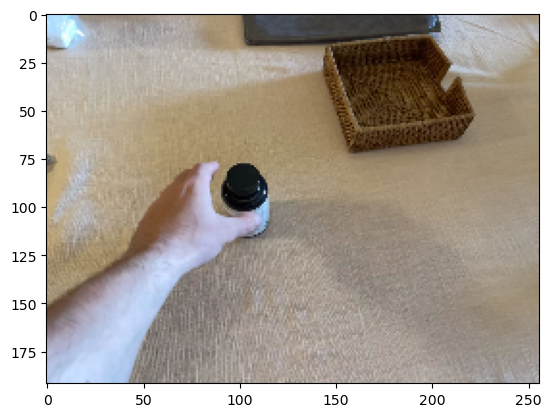

/Users/george/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


downsampling_factor=0.5169466336568197


/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/hamer/hamer/utils/geometry.py:61: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/aten/src/ATen/native/Cross.cpp:67.)
  b3 = torch.cross(b1, b2)


Batch size: 1
[render_rgba_multiple] Focal length: 918.0
[render_rgba_multiple] Camera center: [tensor(128.), tensor(96.)]


In [5]:
index_im = 60
rgb = hands_rgb[index_im]
plt.imshow(rgb)
plt.show()

depth = hands_depth[index_im] / 1000
depth = np.array(depth).astype(np.float32)
rgb_im, rgb_hand_only, rend_depth_front_view, det_out, hamer_output, hand_mesh_params, all_mesh_params = get_hand_and_rendered_depth(rgb)
depth_im = depth
human_mask = get_hand_mask_from_detectron(det_out)
all_meshes, all_cameras, all_vertices = all_mesh_params[0], all_mesh_params[1], all_mesh_params[2]
hand_mesh, hand_camera_translation, mano_vertices = hand_mesh_params[0], hand_mesh_params[1], hand_mesh_params[2]
rgb_hand_only = rgb_hand_only[:,:,:3]

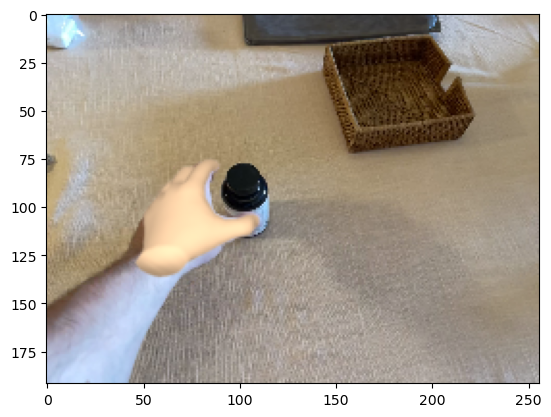

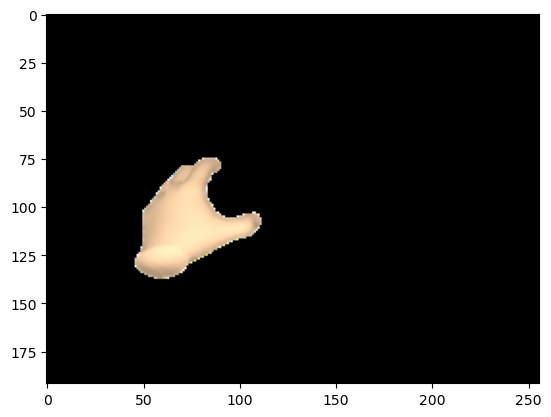

In [6]:


plt.imshow(rgb_im)
plt.show()


rgb_hand_only = rgb_hand_only[:,:,:3]
plt.imshow(rgb_hand_only[:,:,:3])
plt.show()


In [10]:
hammer_pred_kpts = hamer_output['pred_keypoints_2d']
hamer_output


{'pred_cam': tensor([[6.9561, 0.0498, 0.0431]]),
 'pred_mano_params': {'global_orient': tensor([[[[ 0.1336,  0.5768, -0.8059],
            [ 0.8643, -0.4657, -0.1901],
            [-0.4850, -0.6711, -0.5608]]]]),
  'hand_pose': tensor([[[[ 0.9087, -0.3708, -0.1918],
            [ 0.3733,  0.9274, -0.0240],
            [ 0.1867, -0.0498,  0.9811]],
  
           [[ 0.9234, -0.3783,  0.0654],
            [ 0.3833,  0.8994, -0.2103],
            [ 0.0208,  0.2193,  0.9754]],
  
           [[ 0.9721, -0.2220, -0.0754],
            [ 0.2151,  0.9724, -0.0901],
            [ 0.0933,  0.0714,  0.9931]],
  
           [[ 0.8065, -0.5901, -0.0383],
            [ 0.5912,  0.8037,  0.0669],
            [-0.0087, -0.0766,  0.9970]],
  
           [[ 0.9510, -0.2692, -0.1519],
            [ 0.2992,  0.9251,  0.2337],
            [ 0.0776, -0.2678,  0.9604]],
  
           [[ 0.9826, -0.1755, -0.0614],
            [ 0.1739,  0.9843, -0.0308],
            [ 0.0658,  0.0196,  0.9976]],
  
           [

/var/folders/ts/z_8pnkhj06v532vh976r4yxc0000gn/T/ipykernel_61989/1535023789.py:719: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  model_data = pickle.load(mano_file, encoding='latin1')


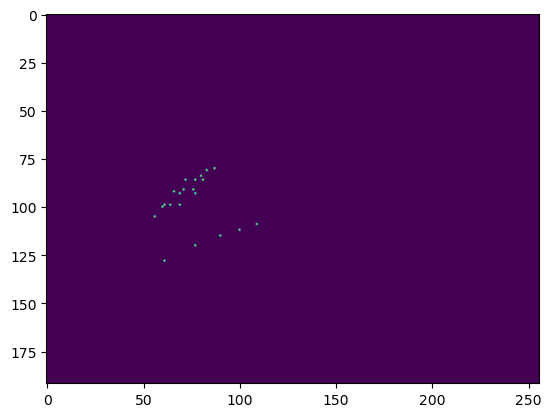

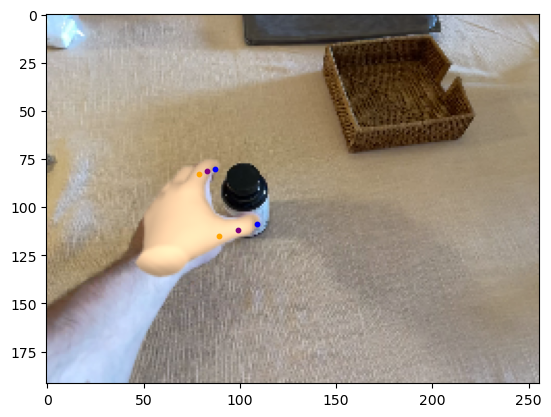

In [14]:
joint_meshes, joints_coords = get_joints_of_hand_mesh(copy.deepcopy(all_meshes[0]), copy.deepcopy(all_vertices[0]), copy.deepcopy(all_cameras[0]))
middle_x, middle_y, index_finger_1_x, index_finger_1_y, index_finger_2_x, index_finger_2_y, index_finger_3_x, index_finger_3_y, thumb_1_x, thumb_1_y, thumb_2_x, thumb_2_y, thumb_3_x, thumb_3_y = get_hand_keypoints_from_mano_model(joints_coords, rgb_im=rgb_im, vizualize=True)
MANO_HAND_IDS = {"wrist": 0, "index_mcp": 1, "index_pip": 2, "index_dip": 3, "middle_mcp": 4, "middle_pip": 5, "middle_dip": 6, "pinkie_mcp": 7, "pinkie_pip": 8, "pinkie_dip": 9,
                "ring_mcp": 10, "ring_pip": 11, "ring_dip": 12, "thumb_mcp": 13, "thumb_pip": 14, "thumb_dip": 15, "thumb_tip": 16, "index_tip": 17, "middle_tip": 18, "ring_tip": 19,
                "pinky_tip": 20}
scaling_factor = None



In [234]:
##### SCALE THE RENDERED DEPTH IMAGE TO MATCH THE REAL DEPTH IMAGE #####
# TODO: NEED TO ENSURE THAT SELECTED PIXEL IS ON THE HUMAN HAND BASED ON HAND MASK  
# middle_x, middle_y, index_finger_1_x, index_finger_1_y, index_finger_2_x, index_finger_2_y, index_finger_3_x, index_finger_3_y, thumb_1_x, thumb_1_y, thumb_2_x, thumb_2_y, thumb_3_x, thumb_3_y = get_hand_keypoints_from_mediapipe(rgb_im, viz_keypoints=True)
d_val = -1
base_value_finger = 'index' # index, middle, thumb
base_val = copy.deepcopy(rend_depth_front_view[index_finger_1_y, index_finger_1_x])
idx_x, idx_y = index_finger_1_x, index_finger_1_y
if base_val == 0 or depth_im[idx_y, idx_x] == 0:
    base_value_finger = 'middle' # index, middle, thumb
    base_val = copy.deepcopy(rend_depth_front_view[middle_y, middle_x])
    idx_x, idx_y = middle_x, middle_y
    if base_val == 0 or depth_im[idx_y, idx_x] == 0:
        base_value_finger = 'thumb'
        base_val = copy.deepcopy(rend_depth_front_view[thumb_1_y, thumb_1_x])
        idx_x, idx_y = thumb_1_x, thumb_1_y
d_val = copy.deepcopy(depth_im[idx_y, idx_x])
percentage_rend_depth_front_view = rend_depth_front_view / base_val
new_depth_image = percentage_rend_depth_front_view * d_val
scaling_factor = d_val / base_val
print(f'Scaling factor {base_value_finger}: {scaling_factor}')

Scaling factor index: 0.21248143911361694


[0.616 0.616 0.617 0.616 0.614 0.613 0.599 0.594 0.597 0.596 0.595 0.592
 0.586 0.575 0.547 0.612 0.596 0.6   0.601 0.572 0.56  0.567 0.578 0.574
 0.573 0.524 0.568]


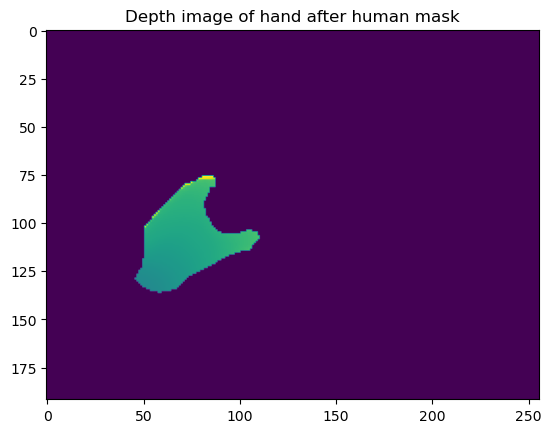

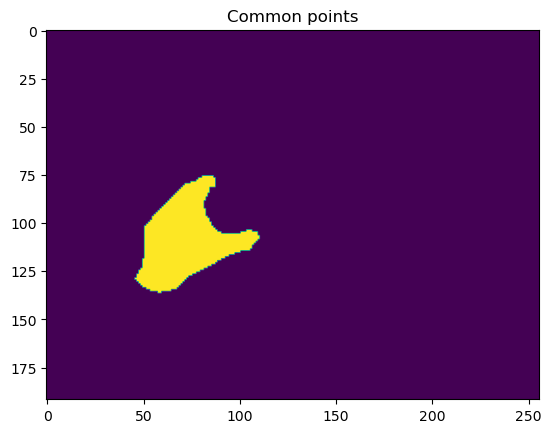

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [12]:
hand_point_cloud, hand_point_cloud_full, image_point_cloud, hand_pcd_as_o3d, live_image_pcd_as_o3d, T_mesh_to_live = get_hand_pcd_in_scene_from_rendered_model(rgb_im, 
                                                                                                                                               depth_im, 
                                                                                                                                               rend_depth_front_view, 
                                                                                                                                               rend_depth_front_view, 
                                                                                                                                               human_mask, 
                                                                                                                                               vizualize=True)

In [15]:
if scaling_factor is None:
    scaling_factor = 1
    print("Scaling factor not found, setting it to 1")
joint_meshes, joints_coords = get_joints_of_hand_mesh(copy.deepcopy(all_meshes[0]), copy.deepcopy(all_vertices[0]), copy.deepcopy(all_cameras[0]))
mesh_live, joints_live, _ = mesh_and_joints_to_world_metric_space(copy.deepcopy(all_meshes[0]), 
                                                               copy.deepcopy(joints_coords), 
                                                               T_mesh_to_live, 
                                                               scaling_factor, 
                                                               live_image_pcd=live_image_pcd_as_o3d, 
                                                               vizualize=True)

thumb_joints = joints_live[-3:]
index_joints = joints_live[:]  
print(joints_live.shape)


Scaling factor not found, setting it to 1
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


/var/folders/ts/z_8pnkhj06v532vh976r4yxc0000gn/T/ipykernel_61989/1535023789.py:719: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  model_data = pickle.load(mano_file, encoding='latin1')


(21, 3)


In [ ]:

pcd_mesh = o3d.geometry.PointCloud()
pcd_mesh.points = o3d.utility.Vector3dVector(mesh_live)
# pcd joints as speheres
pcd_joints = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=joints_live[0])


# for j in thumb_joints:
#     print(j)
#     sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.005)
#     sphere.compute_vertex_normals()
#     sphere.paint_uniform_color([1, 0, 0])
#     sphere.translate(j)
#     pcd_joints += sphere


for j in index_joints:
    print(j)
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=.005)
    sphere.compute_vertex_normals()
    sphere.paint_uniform_color([0, 1, 0])
    sphere.translate(j)
    pcd_joints += sphere
    o3d.visualization.draw_geometries([pcd_mesh, pcd_joints])
    # rotate around the objext
    # rotate around the object


MANO_HAND_IDS = {"wrist": 0, "index_mcp": 1, "index_pip": 2, "index_dip": 3, "middle_mcp": 4, "middle_pip": 5, "middle_dip": 6, "pinkie_mcp": 7, "pinkie_pip": 8, "pinkie_dip": 9,
                "ring_mcp": 10, "ring_pip": 11, "ring_dip": 12, "thumb_mcp": 13, "thumb_pip": 14, "thumb_dip": 15, "thumb_tip": 16, "index_tip": 17, "middle_tip": 18, "ring_tip": 19,
                "pinky_tip": 20}



In [16]:
t = time.time()
gripper_pcd = np.load('gripper_point_cloud_dense.npy')
gripper_pcd = gripper_pcd / 1000 # scale down by 1000
gripper_pcd_as_o3d = o3d.geometry.PointCloud()
gripper_pcd_as_o3d.points = o3d.utility.Vector3dVector(gripper_pcd)
print(f'Loaded gripper point cloud in: {time.time() - t} seconds')
hand_pcd_temp = hand_point_cloud_full.reshape(IM_HEIGHT, IM_WIDTH, 3)

gripper_aligned_to_hand_pcd_as_o3d = align_gripper_to_hand(hand_point_cloud, 
                                                           hand_pcd_as_o3d, 
                                                           gripper_pcd, 
                                                           gripper_pcd_as_o3d, 
                                                           vizualize=True)
# key_fingers_points = np.array([hand_pcd_temp[index_finger_1_y, index_finger_1_x], 
#                                hand_pcd_temp[index_finger_2_y, index_finger_2_x], 
#                                 hand_pcd_temp[index_finger_3_y, index_finger_3_x],
#                                 hand_pcd_temp[thumb_1_y, thumb_1_x], 
#                                 hand_pcd_temp[thumb_2_y, thumb_2_x], 
#                                 hand_pcd_temp[thumb_3_y, thumb_3_x]])

key_fingers_points = np.array([joints_live[MANO_HAND_IDS["index_tip"]], #(joints_live[MANO_HAND_IDS["index_dip"]] + joints_live[MANO_HAND_IDS["index_tip"]] )/2, # this is done because the gripper does now have an unequal length of thumb and index as the human hand does
                                joints_live[MANO_HAND_IDS["index_dip"]],
                                joints_live[MANO_HAND_IDS["index_pip"]],
                                joints_live[MANO_HAND_IDS["thumb_tip"]], 
                                joints_live[MANO_HAND_IDS["thumb_dip"]], 
                                joints_live[MANO_HAND_IDS["thumb_pip"]], 
                                joints_live[MANO_HAND_IDS["wrist"]],
                                (joints_live[MANO_HAND_IDS["index_mcp"]] + joints_live[MANO_HAND_IDS["thumb_dip"]]) / 2])

key_fingers_points = key_fingers_points.reshape(-1, 3)

# gripper_scaled_to_hand_pcd = scale_gripper_match_hand(gripper_aligned_to_hand_pcd_as_o3d, 
#                                                       hand_pcd_as_o3d, 
#                                                       vizualize=True)

gripper_scaled_to_hand_pcd = copy.deepcopy(gripper_aligned_to_hand_pcd_as_o3d) # replace, so no scale applied

gripper_scaled_to_hand_pcd.paint_uniform_color([0, 0, 1])



Loaded gripper point cloud in: 0.02335381507873535 seconds
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


PointCloud with 1000000 points.

In [17]:
bias_T  = np.eye(4)
bias_T[2, 3] = 0.02
gripper_scaled_to_hand_pcd, gripper_pose = align_gripper_with_hand_fingers(gripper_scaled_to_hand_pcd, 
                                                             np_to_o3d(mesh_live), 
                                                             key_fingers_points, 
                                                             gripper_aligned_to_hand_pcd_as_o3d,
                                                             gripper_pcd_as_o3d, 
                                                             use_only_thumb_keypoints=False,
                                                             use_only_index_keypoints=False,
                                                             rescale_gripper_to_hand_opening=False,
                                                             rescale_hand_to_gripper_opening=False,
                                                             bias_transformation=bias_T,
                                                             vizualize=True)

# gripper_pose = get_gripper_transform_in_camera_frame(gripper_scaled_to_hand_pcd, 
#                                                      gripper_pcd_as_o3d, 
#                                                      vizualize=True)

coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
coord_frame.transform(gripper_pose)
o3d.visualization.draw_geometries([live_image_pcd_as_o3d, gripper_scaled_to_hand_pcd, coord_frame])

Distance between pt1 and pt2: 0.11195197389384533
Distance between gripper fingers: 0.08538517347425596
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


### Load and viz stuff

In [137]:
# IMPORTS, FILE LOADS, DETECTRON, RENDERER PREP ETC.
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os

In [227]:
start = 390
end = 510
FRAME_STEP = 30
hamer_path = "/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/hamer"
hands_rgb = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/iphone_vid_2/rgb.npy")[start:end]
hands_depth = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/iphone_vid_2/depth.npy")[start:end]
intrinsics_camera = np.load("/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/3d-hand-pose/iphone_vid_2/intrinsics_iphone.npy")
parsed_scene_files = os.path.join(hamer_path, "scene_files_iphone_vid_2")
gripper_pcds = []
gripper_poses = []
live_image_pcds = []
actual_depth = []
meshes = []

for i in range(0, hands_rgb.shape[0], FRAME_STEP):
    try:
        gripper_pcd = o3d.io.read_point_cloud(os.path.join(parsed_scene_files, f"gripper_pcd_{i}.ply"))
        if gripper_pcd.get_oriented_bounding_box().volume() < .5:
            gripper_pose = np.load(os.path.join(parsed_scene_files, f"gripper_pose_{i}.npy"))
            live_image_pcd = o3d.io.read_point_cloud(os.path.join(parsed_scene_files, f"live_image_pcd_{i}.ply"))
            mesh = o3d.io.read_triangle_mesh(os.path.join(parsed_scene_files, f"hand_mesh_{i}.ply"))
            # set random color for mesh

            # subsample gripper pcd
            gripper_pcd = np.asarray(gripper_pcd.points)
            gripper_pcd_subsampled = gripper_pcd[np.random.choice(gripper_pcd.shape[0], 10000, replace=False)]

            #gripper pcd to o3d
            gripper_pcd = o3d.geometry.PointCloud()
            gripper_pcd.points = o3d.utility.Vector3dVector(gripper_pcd_subsampled)
                                    
            mesh.paint_uniform_color(np.random.rand(3))
            gripper_pcd.paint_uniform_color(np.random.rand(3))

            meshes.append(mesh)
            gripper_pcds.append(gripper_pcd)
            gripper_poses.append(gripper_pose)
            live_image_pcds.append(live_image_pcd)
            depth = hands_depth[i] / 1000
            # rgb = hands_rgb[i]
            # depth_pcd = depth_to_point_cloud(depth, intrinsics_camera[0, 0], intrinsics_camera[1, 1], intrinsics_camera[0, 2], intrinsics_camera[1, 2])
            # depth_pcd = depth_pcd.reshape(-1, 3)
            # depth_pcd_o3d = o3d.geometry.PointCloud()
            # depth_pcd_o3d.points = o3d.utility.Vector3dVector(depth_pcd)
            # depth_pcd_o3d.colors = o3d.utility.Vector3dVector(rgb.reshape(-1, 3) / 255)
            # actual_depth.append(depth_pcd_o3d)


    except:
        print(f"Could not read point clouds at {i}")





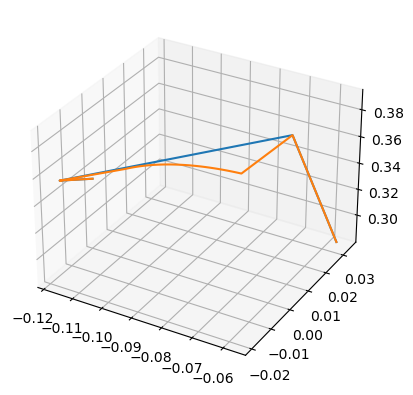

In [221]:
# smooth gripper_poses trajectory


interpolated_gripper_poses = interpolate_pose_sequence(gripper_poses, 30)
interpolated_gripper_poses_xyz = []
for pose in interpolated_gripper_poses:
    interpolated_gripper_poses_xyz.append(pose[:3, 3])
interpolated_gripper_poses_xyz = np.array(interpolated_gripper_poses_xyz)

# smooth using a simple moving average
window_size = 30
interpolated_gripper_poses_filtered = copy.deepcopy(interpolated_gripper_poses_xyz)
for i in range(window_size, interpolated_gripper_poses_xyz.shape[0] - window_size):
    interpolated_gripper_poses_filtered[i] = np.mean(interpolated_gripper_poses_xyz[i - window_size: i + window_size], axis=0)

# for i in range(len(interpolated_gripper_poses_filtered)):
#     interpolated_gripper_poses[i, :3, 3] = interpolated_gripper_poses_filtered[i]


gripper_pcd0  = gripper_pcds[0]
gripper_pose0 = gripper_poses[0]
gripper_pose0_inv = np.linalg.inv(gripper_pose0)

interpolated_gripper_poses_coord_frames = []
interpolated_gripper_pcds = []
for pose in interpolated_gripper_poses:
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
    coord_frame.transform(pose)
    interpolated_gripper_poses_coord_frames.append(coord_frame)
    interpolated_gripper_pcds.append(copy.deepcopy(gripper_pcd0).transform(pose @ gripper_pose0_inv))




# plot in 3D the filtered and non filtered path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(interpolated_gripper_poses_xyz[:, 0], interpolated_gripper_poses_xyz[:, 1], interpolated_gripper_poses_xyz[:, 2], label='Original path')
ax.plot(interpolated_gripper_poses_filtered[:, 0], interpolated_gripper_poses_filtered[:, 1], interpolated_gripper_poses_filtered[:, 2], label='Filtered path')


plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


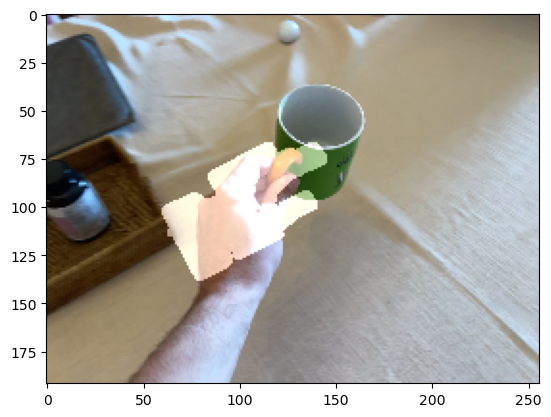

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [240]:
# vizualize all the point clouds and gripper transformation
######## INTRINSICS EXTRACTED FROM HAMER RENDERER ########
intr = np.eye(4)
# intr[0 ,0] = 2295.0
# intr[1, 1] = 2295.0
# intr[0, 2] = 320.0
# intr[1, 2] = 240.0

intr[0 ,0] = 918.0
intr[1, 1] = 918.0
intr[0, 2] = 128.0
intr[1, 2] = 96.0
################


gripper_coord_frames = []
world_coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100, origin=[0, 0, 0])
gripper_projections = []
for i in range(len(gripper_pcds)):
    gripper_pcd = gripper_pcds[i]
    gripper_pcd_np = np.asarray(gripper_pcd.points)
    gripper_pcd_depth_im = point_cloud_to_depth_image(gripper_pcd_np, 
                                                      intrinsics_camera[0, 0], 
                                                      intrinsics_camera[1, 1], 
                                                      intrinsics_camera[0, 2], 
                                                      intrinsics_camera[1, 2],
                                                      width=IM_WIDTH,
                                                      height=IM_HEIGHT)
    gripper_projections.append(gripper_pcd_depth_im)

    
    gripper_pose = gripper_poses[i]
    live_image_pcd = live_image_pcds[i]
    # actual_depth_pcd = actual_depth[i]
    gripper_coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.100)
    gripper_coord_frame.transform(gripper_pose)
    gripper_coord_frames.append(gripper_coord_frame)
    # o3d.visualization.draw_geometries([actual_depth_pcd])
    # o3d.visualization.draw_geometries([actual_depth_pcd, gripper_pcd, live_image_pcd, world_coord_frame, gripper_coord_frame])
start_idx = 3
subsampling = 3

# gripper to 2 channels
gripper_proj = gripper_projections[start_idx][:, :, np.newaxis] 
gripper_proj[gripper_proj > 0] = 1

# project gripper pcd to the live image

plt.imshow(.5 * gripper_proj + 1 * hands_rgb[start_idx * 30]/255)
plt.show()
o3d.visualization.draw_geometries([live_image_pcd_as_o3d, gripper_scaled_to_hand_pcd, live_image_pcds[start_idx], gripper_coord_frames[start_idx], meshes[start_idx], gripper_pcds[start_idx], interpolated_gripper_pcds[start_idx * 30-1], interpolated_gripper_poses_coord_frames[start_idx], meshes[start_idx]])

# for start_idx in range(0, len(gripper_pcds)):
    # o3d.visualization.draw_geometries([live_image_pcds[start_idx], gripper_coord_frames[start_idx], meshes[start_idx], gripper_pcds[start_idx], interpolated_gripper_pcds[start_idx * 30], interpolated_gripper_poses_coord_frames[start_idx], meshes[start_idx]])
# o3d.visualization.draw_geometries([live_image_pcds[0]] + gripper_coord_frames[start_idx::subsampling] + meshes[start_idx::subsampling] + gripper_pcds[start_idx::subsampling])
# o3d.visualization.draw_geometries(live_image_pcds[::subsampling] + gripper_coord_frames[::subsampling] + gripper_pcds[::subsampling])




In [ ]:
interpolated_gripper_projections = []
for i in range(len(interpolated_gripper_pcds)):
    gripper_pcd = interpolated_gripper_pcds[i]
    gripper_pcd_np = np.asarray(gripper_pcd.points)
    gripper_pcd_depth_im = point_cloud_to_depth_image(gripper_pcd_np, 
                                                      intrinsics_camera[0, 0], 
                                                      intrinsics_camera[1, 1], 
                                                      intrinsics_camera[0, 2], 
                                                      intrinsics_camera[1, 2],
                                                      width=IM_WIDTH,
                                                      height=IM_HEIGHT)
    interpolated_gripper_projections.append(gripper_pcd_depth_im)


gripper_projections_sub = gripper_projections[0::10]
gripper_proj_in_one_img = gripper_projections_sub[0]
 
for grip_proj in gripper_projections_sub[1:]:
    gripper_proj_in_one_img += grip_proj

gripper_proj_in_one_img[gripper_proj_in_one_img > 0] = 1
girpper_proj_in_one_img = gripper_proj_in_one_img[:, :, np.newaxis]
print(gripper_proj_in_one_img[:, :, np.newaxis].shape)
plt.imshow(gripper_proj_in_one_img)
plt.show()



In [ ]:
# show rgbs as video
print(hands_rgb.shape, len(interpolated_gripper_projections))
cnt = 0
cnt_gripper_proj = 0
video_ims = []
for i in range(0, hands_rgb.shape[0]):
    gripper_proj = interpolated_gripper_projections[cnt][:, :, np.newaxis] 
    gripper_proj[gripper_proj > 0] = 1
    im = .5 * gripper_proj + 1 * hands_rgb[i]/255 + 0.5 * gripper_projections[cnt_gripper_proj][:, :, np.newaxis].repeat(3, axis=2) * np.array([0, 1, 0])

    if cnt % 30 == 0:
        cnt_gripper_proj += 1

    im = im[..., ::-1]
    video_ims.append(im)
    # im = cv2.cvtColor(hands_depth[i],cv2.COLOR_GRAY2BGR)
    cv2.imshow("rgb", im)

    cv2.waitKey(1)
    time.sleep(0.01)
    cnt += 1
    if cnt >= len(interpolated_gripper_projections) or cnt_gripper_proj >= len(gripper_projections):
        break

cv2.destroyAllWindows()

# save video as mp4 
height, width, layers = video_ims[0].shape
size = (width,height)
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
for i in range(len(video_ims)):
    out.write((video_ims[i] * 255).astype(np.uint8))
out.release()






In [ ]:
print(hamer_output.keys())
mano_params = hamer_output['pred_mano_params']
mano_vertices = hamer_output['pred_vertices']
print(mano_params['betas'].shape)
print(mano_params.keys())
print(mano_params['hand_pose'].shape)
print(mano_params['global_orient'].shape)
print(mano_vertices.shape)
hand_mesh, hand_camera_translation, mano_vertices = hand_mesh_params[0], hand_mesh_params[1], hand_mesh_params[2]
all_meshes, all_cameras, all_vertices = all_mesh_params[0], all_mesh_params[1], all_mesh_params[2]
verts = torch.tensor(mano_vertices).unsqueeze(0)
print(verts.shape)


In [ ]:
hand_mesh_to_show = all_meshes[0]
joint_meshes, joints_coords = get_joints_of_hand_mesh(hand_mesh_to_show, all_vertices[0], all_cameras[0])
mesh_live, joints_live = mesh_and_joints_to_world_metric_space(hand_mesh_to_show, joints_coords, T_mesh_to_live, scaling_factor, live_image_pcd=live_image_pcd_as_o3d, vizualize=True)
# j_meshes = []
# for j in joints_live:
#     joint_mesh = Mesh(vertices=j, radius=.001, vc=colors['green'])
#     j_meshes.append(joint_mesh)
# j_meshes = Mesh.concatenate_meshes(j_meshes)
# scene = trimesh.Scene([trimesh.points.PointCloud(mesh_live, colors=[0, 100, 100, 255]), j_meshes])
# scene.show(flags={"axis": True})

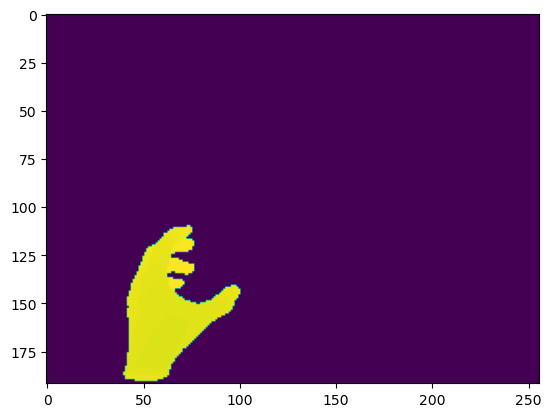

K--- [[918.   0. 128.]
 [  0. 918.  96.]
 [  0.   0.   1.]] [[918.   0. 128.   0.]
 [  0. 918.  96.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
[[-0.03118617  0.0079383   0.5205256 ]
 [-0.03062741  0.00794044  0.520666  ]
 [-0.0349212   0.00844868  0.517059  ]
 ...
 [-0.04071405  0.05242632  0.51199317]
 [-0.04015134  0.05241981  0.51192963]
 [-0.03958887  0.05241343  0.51186734]]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [71]:
import pyrender
import trimesh
import numpy as np
from trimesh.transformations import rotation_matrix


T_OPENGL_TO_OPENCV = np.array(
    [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
)
VIEWPORT_WIDTH = depth_im.shape[1]
VIEWPORT_HEIGHT = depth_im.shape[0]
MESH_FILE = "bunny.obj"


def opengl_projection_matrix_to_intrinsics(P: np.ndarray, width: int, height: int):
    """Convert OpenGL projection matrix to camera intrinsics.
    Args:
        P (np.ndarray): OpenGL projection matrix.
        width (int): Image width.
        height (int): Image height.
    Returns:
        np.ndarray: Camera intrinsics. [3, 3]
    """

    fx = P[0, 0] * width / 2
    fy = P[1, 1] * height / 2
    cx = (1.0 - P[0, 2]) * width / 2
    cy = (1.0 + P[1, 2]) * height / 2

    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    return K


def depth_to_pointcloud(K: np.ndarray, depth: np.ndarray, rgb: np.ndarray = None):
    """Convert depth image to pointcloud given camera intrinsics.
    Args:
        depth (np.ndarray): Depth image.
    Returns:
        np.ndarray: (x, y, z) Point cloud. [n, 4]
        np.ndarray: (r, g, b) RGB colors per point. [n, 3] or None
    """
    _fx = K[0, 0]
    _fy = K[1, 1]
    _cx = K[0, 2]
    _cy = K[1, 2]

    # Mask out invalid depth
    mask = np.where(depth > 0)
    x, y = mask[1], mask[0]

    # Normalize pixel coordinates
    normalized_x = x.astype(np.float32) - _cx
    normalized_y = y.astype(np.float32) - _cy

    # Convert to world coordinates
    world_x = normalized_x * depth[y, x] / _fx
    world_y = normalized_y * depth[y, x] / _fy
    world_z = depth[y, x]

    pc = np.vstack((world_x, world_y, world_z)).T

    # Assign rgb colors to points if available
    if rgb is not None:
        rgb = rgb[y, x, :]

    return pc, rgb


def render_offscreen(
    mesh: pyrender.Mesh, camera: pyrender.Camera, camera_pose: np.ndarray
):
    """Render mesh offscreen.
    Args:
        mesh (pyrender.Mesh): Mesh object.
        camera (pyrender.Camera): Camera object.
        camera_pose (np.ndarray): Camera pose.
    Returns:
        np.ndarray:  Rendered color image. [H, W, 3]
        np.ndarray:  Rendered depth image. [H, W]
    """
    # Scene
    scene = pyrender.Scene()

    # Mesh
    scene.add(mesh)

    # Camera- pose is w.r.t the scene frame (alternatively, set the parent node)
    scene.add(camera, pose=camera_pose, parent_node=None)

    # Light
    light = pyrender.SpotLight(
        color=np.ones(3),
        intensity=0.5,
        innerConeAngle=np.pi / 16.0,
        outerConeAngle=np.pi / 6.0,
    )
    scene.add(light, pose=camera_pose)

    # Render
    r = pyrender.OffscreenRenderer(VIEWPORT_WIDTH, VIEWPORT_HEIGHT)
    color, depth = r.render(scene)
    return color, depth
intr = np.eye(4)
intr[0 ,0] = 918.0
intr[1, 1] = 918.0
intr[0, 2] = 128.0
intr[1, 2] = 96.0
render_res = [128.0, 96.0]
# Mesh OBJ
mesh = copy.deepcopy(all_meshes[0])
joint_mesh = copy.deepcopy(joint_meshes[0])
mesh_pyrender = pyrender.Mesh.from_trimesh(mesh)
camera_pose = np.eye(4)
camera_center = [render_res[0], render_res[1] ]
focal_length = 918.0
# print(rend_depth_front_view.shape)
camera = pyrender.IntrinsicsCamera(fx=focal_length, fy=focal_length,
                                           cx=camera_center[0], cy=camera_center[1], zfar=1e12)
# Camera model
# camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)

# Random Camera Pose - This pose is w.r.t the scene parent node
camera_pose_scene = np.eye(4)
# camera_pose_scene[:3, 3] = [0.1, 0.1, 0.5]

# Find camera pose transform that rotates the object randomly around its frame
# random_rotation = np.eye(4)
# obj_pose_camera = np.linalg.inv(camera_pose_scene) @ random_rotation
# camera_pose_scene = np.linalg.inv(obj_pose_camera)

# Render
color, depth = render_offscreen(mesh_pyrender, camera, camera_pose_scene)
plt.imshow(depth)
plt.show()
# Get Intrinsic Matrix
K = opengl_projection_matrix_to_intrinsics(
    camera.get_projection_matrix(width=VIEWPORT_WIDTH, height=VIEWPORT_HEIGHT), width=VIEWPORT_WIDTH/2, height=VIEWPORT_HEIGHT/2)
print("K---", K, intr)
# Deproject depth to point cloud
point_cloud, _ = depth_to_pointcloud(K, new_depth_image)
point_cloud_rescaled_depth = depth_to_point_cloud(new_depth_image, K[0, 0], K[1, 1], K[0, 2],  K[1, 2]).reshape(-1, 3) # Hamer intrinsics, depth at real scale, shape does not match real

print(point_cloud)
# Convert from opengl to opencv camera frame.
# (OpenGL camera has principal axis along -z, OpenCV has principal axis along +z)
cam_pose_z_opencv = camera_pose_scene @ T_OPENGL_TO_OPENCV

# Transform partial point cloud to world coordinates
point_cloud_h = np.hstack((point_cloud, np.ones((point_cloud.shape[0], 1))))
point_cloud_world = (cam_pose_z_opencv @ point_cloud_h.T).T
point_cloud_world = point_cloud_world[:, :3]
points_mesh = mesh.sample(10000)

# points_mesh in camera coordinates
points_mesh = np.linalg.inv(T_OPENGL_TO_OPENCV) @ np.vstack((points_mesh.T, np.ones((1, points_mesh.shape[0]))))
points_mesh = points_mesh[:3, :].T
points_mesh = points_mesh * scaling_factor
points_mesh = apply_transformation(points_mesh, T_mesh_to_live)

# Visualize alignment of partial point cloud in the world frame
# points_mesh = mesh.sample(10000)
# points_mesh in camera coordinates
# points_mesh = np.linalg.inv(cam_pose_z_opencv) @ np.vstack((points_mesh.T, np.ones((1, points_mesh.shape[0]))))
# points_mesh = points_mesh[:3, :].T
# points_mesh = points_mesh * scaling_factor
# points_mesh = apply_transformation(points_mesh, T_mesh_to_live)

mesh.apply_transform(np.linalg.inv(T_OPENGL_TO_OPENCV))
mesh.apply_scale(scaling_factor)
mesh.apply_transform(T_mesh_to_live)




joint_mesh = np.linalg.inv(cam_pose_z_opencv) @ np.vstack((joint_mesh.vertices.T, np.ones((1, joint_mesh.vertices.shape[0]))))

scene = trimesh.Scene(
    [mesh, trimesh.points.PointCloud(points_mesh, colors=[0, 100, 100, 255])]
)
scene.show(flags={"axis": True})

# points_mesh = apply_transformation(point_cloud_rescaled_depth.reshape(-1,3), T_mesh_to_live)
# # # # show live scene o3d
points_mesh_as_o3d = o3d.geometry.PointCloud()
points_mesh_as_o3d.points = o3d.utility.Vector3dVector(points_mesh)
points_mesh_as_o3d.paint_uniform_color([0, 100, 100])

  
#  mesh to o3d
# mesh = trimesh.load(MESH_FILE)
mesh_o3d = o3d.geometry.TriangleMesh()
mesh_o3d.vertices = o3d.utility.Vector3dVector(mesh.vertices)
mesh_o3d.triangles = o3d.utility.Vector3iVector(mesh.faces)
mesh_o3d.compute_vertex_normals()
mesh_o3d.vertex_colors = o3d.utility.Vector3dVector(mesh.visual.vertex_colors[:, :3] / 255.0)



o3d.visualization.draw_geometries([mesh_o3d, live_image_pcd_as_o3d])


In [ ]:
model_path = '/Users/george/Desktop/Main/Imperial College London/PhD/Year 3/Project 3.1/hamer/_DATA/_DATA/data/mano'
is_rhand = True
ext='pkl'
data_struct = None
if data_struct is None:
        # Load the model
        if osp.isdir(model_path):
            model_fn = 'MANO_{}.{ext}'.format('RIGHT' if is_rhand else 'LEFT', ext=ext)
            mano_path = os.path.join(model_path, model_fn)
        else:
            mano_path = model_path
            is_rhand = True if 'RIGHT' in os.path.basename(model_path) else False
        assert osp.exists(mano_path), 'Path {} does not exist!'.format(
            mano_path)
        if ext == 'pkl':
            with open(mano_path, 'rb') as mano_file:
                model_data = pickle.load(mano_file, encoding='latin1')
        elif ext == 'npz':
            model_data = np.load(mano_path, allow_pickle=True)
        else:
            raise ValueError('Unknown extension: {}'.format(ext))
        data_struct = Struct(**model_data)
data_struct.J_regressor = torch.from_numpy(data_struct.J_regressor.todense()).float()
joints_predicted = lbs.vertices2joints(data_struct.J_regressor, torch.FloatTensor(mesh.vertices).unsqueeze(0))



In [ ]:
# joints to p3d sphere
joints = to_np(joints_predicted)
joints = joints.reshape(1,-1,3)
j_meshes = []
for j in joints:
    joint_mesh = Mesh(vertices=j, radius=.01, vc=colors['green'])
    j_meshes.append(joint_mesh)
j_meshes = Mesh.concatenate_meshes(j_meshes)

mesh_samples = mesh.sample(10000)

scene = trimesh.Scene([j_meshes, trimesh.points.PointCloud(mesh_samples, colors=[0, 100, 100, 255])])
scene.show(flags={"axis": True})